
# Evaluation: Competitive Ratio (Batch)
Loop over offline/online solutions and compute competitive ratios for each pair.


In [2]:

from pathlib import Path
import sys
import pandas as pd
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().resolve().parents[1]))
from motion_planning.utils.paths import OFFLINE_RESULTS_DIR, ONLINE_RESULTS_DIR
from motion_planning.evaluation.competitive_ratio import compute_competitive_ratio

# Ensure repo root and src on path
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning



## Locate artifacts


In [4]:
from motion_planning.utils.paths import OFFLINE_RESULTS_DIR, ONLINE_RESULTS_DIR
from motion_planning.evaluation.competitive_ratio import compute_competitive_ratio
# Offline
offline_graph = sorted((OFFLINE_RESULTS_DIR / "solution details").glob("*_offline_graph_solution_edges.csv"))
offline_cand = sorted((OFFLINE_RESULTS_DIR / "problem details").glob("*_offline_candidates_opt.csv"))

# Online
online_graph = sorted((ONLINE_RESULTS_DIR / "graph-based").glob("*_online_ITM-ORB.csv"))
online_cand = sorted((ONLINE_RESULTS_DIR / "candidates").glob("*_online_*ORB.csv"))

print("Counts -> offline:", len(offline_graph), "offline cand:", len(offline_cand))
print("Counts -> online:", len(online_graph), "online cand:", len(online_cand))


Counts -> offline: 1920 offline cand: 1920
Counts -> online: 1920 online cand: 3840


In [3]:
online_cand
online_graph
offline_cand
offline_graph

[PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/solution details/iter10_Town01_T-Intersection_10_high_5_offline_graph_solution_edges.csv'),
 PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/solution details/iter10_Town01_T-Intersection_10_low_5_offline_graph_solution_edges.csv'),
 PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/solution details/iter10_Town01_T-Intersection_10_medium_5_offline_graph_solution_edges.csv'),
 PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/solution details/iter10_Town01_T-Intersection_10_very_high_5_offline_graph_solution_edges.csv'),
 PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/solution details/iter10_Town01_T-Intersection_15_high_5_offline_graph_solution_edges.csv'),
 Pos


## Competitive ratio for graph-based (utility)
Pair offline graph opt with online ITM-ORB by matching the base stem (before suffix).
CR = offline_utility / online_utility (utility objective).


In [4]:

# Build maps by base stem
offline_graph_map = {f.stem.replace("_offline_graph_solution_edges", ""): f for f in offline_graph}
online_graph_map = {f.stem.replace("_online_ITM-ORB", ""): f for f in online_graph}

records = []
for base, off_path in offline_graph_map.items():
    on_path = online_graph_map.get(base)
    if on_path is None:
        continue
    df_off = pd.read_csv(off_path)
    df_on = pd.read_csv(on_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
    cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
    records.append({
        "scenario": base,
        "offline_file": off_path.name,
        "online_file": on_path.name,
        "offline_utility": off_util,
        "online_utility": on_util,
        "cr_utility": cr,
    })

df_graph_cr = pd.DataFrame(records)
display(df_graph_cr)


,scenario,offline_file,online_file,offline_utility,online_utility,cr_utility
0,iter10_Town01_T-Intersection_10_high_5,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1964.976942,1962.236666,1.001397
1,iter10_Town01_T-Intersection_10_low_5,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_I...,1965.044177,1965.044177,1.000000
2,iter10_Town01_T-Intersection_10_medium_5,iter10_Town01_T-Intersection_10_medium_5_offli...,iter10_Town01_T-Intersection_10_medium_5_onlin...,1965.044177,1965.010386,1.000017
3,iter10_Town01_T-Intersection_10_very_high_5,iter10_Town01_T-Intersection_10_very_high_5_of...,iter10_Town01_T-Intersection_10_very_high_5_on...,1965.027281,1963.388213,1.000835
4,iter10_Town01_T-Intersection_15_high_5,iter10_Town01_T-Intersection_15_high_5_offline...,iter10_Town01_T-Intersection_15_high_5_online_...,1965.044177,1965.044177,1.000000
...,...,...,...,...,...,...
1595,iter9_Town05_Highway3_20_very_high_8,iter9_Town05_Highway3_20_very_high_8_offline_g...,iter9_Town05_Highway3_20_very_high_8_online_IT...,4681.689437,4670.674252,1.002358
1596,iter9_Town05_Highway3_25_high_8,iter9_Town05_Highway3_25_high_8_offline_graph_...,iter9_Town05_Highway3_25_high_8_online_ITM-ORB...,4682.140293,4682.044886,1.000020
1597,iter9_Town05_Highway3_25_low_8,iter9_Town05_Highway3_25_low_8_offline_graph_s...,iter9_Town05_Highway3_25_low_8_online_ITM-ORB.csv,4682.140293,4681.811347,1.000070
1598,iter9_Town05_Highway3_25_medium_8,iter9_Town05_Highway3_25_medium_8_offline_grap...,iter9_Town05_Highway3_25_medium_8_online_ITM-O...,4682.140293,4681.710327,1.000092


In [5]:
# df_graph_cr['cr_utility'].describe()


## Competitive ratio for candidates-based (utility)
Pair offline candidates opt with each online candidates run (CZL/BAT). For each match, compute CR = offline_utility / online_utility.


In [6]:

offline_cand_map = {f.stem.replace("_offline_candidates_opt", ""): f for f in offline_cand}
# group online by base stem
online_cand_entries = []
for f in online_cand:
    stem = f.stem
    if "_online_" in stem:
        base, alg = stem.split("_online_", 1)
    else:
        base, alg = stem, "unknown"
    online_cand_entries.append((base, alg, f))

records_cand = []
for base, off_path in offline_cand_map.items():
    df_off = pd.read_csv(off_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    for b, alg, on_path in online_cand_entries:
        if b != base:
            continue
        df_on = pd.read_csv(on_path)
        on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
        cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
        records_cand.append({
            "scenario": base,
            "algorithm": alg,
            "offline_file": off_path.name,
            "online_file": on_path.name,
            "offline_utility": off_util,
            "online_utility": on_util,
            "cr_utility": cr,
        })

df_cand_cr = pd.DataFrame(records_cand)
display(df_cand_cr)


,scenario,algorithm,offline_file,online_file,offline_utility,online_utility,cr_utility
0,iter10_Town01_T-Intersection_10_high_5,BAT-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1963.498591,1940.256165,1.011979
1,iter10_Town01_T-Intersection_10_high_5,CZL-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1963.498591,1940.256165,1.011979
2,iter10_Town01_T-Intersection_10_low_5,BAT-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_B...,1965.044177,1965.044177,1.000000
3,iter10_Town01_T-Intersection_10_low_5,CZL-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_C...,1965.044177,1965.044177,1.000000
4,iter10_Town01_T-Intersection_10_medium_5,BAT-ORB,iter10_Town01_T-Intersection_10_medium_5_offli...,iter10_Town01_T-Intersection_10_medium_5_onlin...,1965.044177,1962.990317,1.001046
...,...,...,...,...,...,...,...
3195,iter9_Town05_Highway3_25_low_8,CZL-ORB,iter9_Town05_Highway3_25_low_8_offline_candida...,iter9_Town05_Highway3_25_low_8_online_CZL-ORB.csv,4682.140293,4681.811347,1.000070
3196,iter9_Town05_Highway3_25_medium_8,BAT-ORB,iter9_Town05_Highway3_25_medium_8_offline_cand...,iter9_Town05_Highway3_25_medium_8_online_BAT-O...,4682.049437,4682.049437,1.000000
3197,iter9_Town05_Highway3_25_medium_8,CZL-ORB,iter9_Town05_Highway3_25_medium_8_offline_cand...,iter9_Town05_Highway3_25_medium_8_online_CZL-O...,4682.049437,4681.390654,1.000141
3198,iter9_Town05_Highway3_25_very_high_8,BAT-ORB,iter9_Town05_Highway3_25_very_high_8_offline_c...,iter9_Town05_Highway3_25_very_high_8_online_BA...,4678.830352,4678.110352,1.000154


In [7]:
df_cand_cr[df_cand_cr['algorithm'] == 'BAT-ORB']['cr_utility'].describe()

count    1600.000000
mean        1.001807
std         0.004723
min         1.000000
25%         1.000000
50%         1.000033
75%         1.000862
max         1.040558
Name: cr_utility, dtype: float64

In [8]:
df_cand_cr[df_cand_cr['algorithm'] == 'CZL-ORB']['cr_utility'].describe()

count    1600.000000
mean        1.002095
std         0.004854
min         1.000000
25%         1.000000
50%         1.000057
75%         1.001283
max         1.040558
Name: cr_utility, dtype: float64

In [9]:
df_cand_cr['cr_utility'].describe()

count    3200.000000
mean        1.001951
std         0.004790
min         1.000000
25%         1.000000
50%         1.000047
75%         1.001087
max         1.040558
Name: cr_utility, dtype: float64

In [10]:

offline_cand_map = {f.stem.replace("_offline_candidates_opt", ""): f for f in offline_cand}
# group online by base stem
online_cand_entries = []
for f in online_cand:
    stem = f.stem
    if "_online_" in stem:
        base, alg = stem.split("_online_", 1)
    else:
        base, alg = stem, "unknown"
    online_cand_entries.append((base, alg, f))

records_cand = []
for base, off_path in offline_cand_map.items():
    df_off = pd.read_csv(off_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    for b, alg, on_path in online_cand_entries:
        if b != base:
            continue
        df_on = pd.read_csv(on_path)
        on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
        cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
        records_cand.append({
            "scenario": base,
            "algorithm": alg,
            "offline_file": off_path.name,
            "online_file": on_path.name,
            "offline_utility": off_util,
            "online_utility": on_util,
            "cr_utility": cr,
        })

df_cand_cr = pd.DataFrame(records_cand)
display(df_cand_cr)



# Build maps by base stem
offline_graph_map = {f.stem.replace("_offline_graph_solution_edges", ""): f for f in offline_graph}
online_graph_map = {f.stem.replace("_online_ITM-ORB", ""): f for f in online_graph}

records = []
for base, off_path in offline_graph_map.items():
    on_path = online_graph_map.get(base)
    if on_path is None:
        continue
    df_off = pd.read_csv(off_path)
    df_on = pd.read_csv(on_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
    cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
    records.append({
        "scenario": base,
        "offline_file": off_path.name,
        "online_file": on_path.name,
        "offline_utility": off_util,
        "online_utility": on_util,
        "cr_utility": cr,
    })

df_graph_cr = pd.DataFrame(records)
display(df_graph_cr)


,scenario,algorithm,offline_file,online_file,offline_utility,online_utility,cr_utility
0,iter10_Town01_T-Intersection_10_high_5,BAT-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1963.498591,1940.256165,1.011979
1,iter10_Town01_T-Intersection_10_high_5,CZL-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1963.498591,1940.256165,1.011979
2,iter10_Town01_T-Intersection_10_low_5,BAT-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_B...,1965.044177,1965.044177,1.000000
3,iter10_Town01_T-Intersection_10_low_5,CZL-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_C...,1965.044177,1965.044177,1.000000
4,iter10_Town01_T-Intersection_10_medium_5,BAT-ORB,iter10_Town01_T-Intersection_10_medium_5_offli...,iter10_Town01_T-Intersection_10_medium_5_onlin...,1965.044177,1962.990317,1.001046
...,...,...,...,...,...,...,...
3195,iter9_Town05_Highway3_25_low_8,CZL-ORB,iter9_Town05_Highway3_25_low_8_offline_candida...,iter9_Town05_Highway3_25_low_8_online_CZL-ORB.csv,4682.140293,4681.811347,1.000070
3196,iter9_Town05_Highway3_25_medium_8,BAT-ORB,iter9_Town05_Highway3_25_medium_8_offline_cand...,iter9_Town05_Highway3_25_medium_8_online_BAT-O...,4682.049437,4682.049437,1.000000
3197,iter9_Town05_Highway3_25_medium_8,CZL-ORB,iter9_Town05_Highway3_25_medium_8_offline_cand...,iter9_Town05_Highway3_25_medium_8_online_CZL-O...,4682.049437,4681.390654,1.000141
3198,iter9_Town05_Highway3_25_very_high_8,BAT-ORB,iter9_Town05_Highway3_25_very_high_8_offline_c...,iter9_Town05_Highway3_25_very_high_8_online_BA...,4678.830352,4678.110352,1.000154


,scenario,offline_file,online_file,offline_utility,online_utility,cr_utility
0,iter10_Town01_T-Intersection_10_high_5,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1964.976942,1962.236666,1.001397
1,iter10_Town01_T-Intersection_10_low_5,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_I...,1965.044177,1965.044177,1.000000
2,iter10_Town01_T-Intersection_10_medium_5,iter10_Town01_T-Intersection_10_medium_5_offli...,iter10_Town01_T-Intersection_10_medium_5_onlin...,1965.044177,1965.010386,1.000017
3,iter10_Town01_T-Intersection_10_very_high_5,iter10_Town01_T-Intersection_10_very_high_5_of...,iter10_Town01_T-Intersection_10_very_high_5_on...,1965.027281,1963.388213,1.000835
4,iter10_Town01_T-Intersection_15_high_5,iter10_Town01_T-Intersection_15_high_5_offline...,iter10_Town01_T-Intersection_15_high_5_online_...,1965.044177,1965.044177,1.000000
...,...,...,...,...,...,...
1595,iter9_Town05_Highway3_20_very_high_8,iter9_Town05_Highway3_20_very_high_8_offline_g...,iter9_Town05_Highway3_20_very_high_8_online_IT...,4681.689437,4670.674252,1.002358
1596,iter9_Town05_Highway3_25_high_8,iter9_Town05_Highway3_25_high_8_offline_graph_...,iter9_Town05_Highway3_25_high_8_online_ITM-ORB...,4682.140293,4682.044886,1.000020
1597,iter9_Town05_Highway3_25_low_8,iter9_Town05_Highway3_25_low_8_offline_graph_s...,iter9_Town05_Highway3_25_low_8_online_ITM-ORB.csv,4682.140293,4681.811347,1.000070
1598,iter9_Town05_Highway3_25_medium_8,iter9_Town05_Highway3_25_medium_8_offline_grap...,iter9_Town05_Highway3_25_medium_8_online_ITM-O...,4682.140293,4681.710327,1.000092



## Unified solutions table
Build a single flattened DataFrame that aligns each scenario with its offline optima (graph + candidates) and online outputs (CZL, BAT, ITM), keeping per-solution details (nodes/edges/speeds, per-element risks/costs/utilities, and totals).


In [11]:

from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem

cand_dir = OFFLINE_RESULTS_DIR / "problem details"
graph_sol_dir = OFFLINE_RESULTS_DIR / "solution details"
online_cand_dir = ONLINE_RESULTS_DIR / "candidates"
online_graph_dir = ONLINE_RESULTS_DIR / "graph-based"

offline_graph = sorted(graph_sol_dir.glob("*_offline_graph_solution_edges.csv"))
offline_cand = sorted(cand_dir.glob("*_offline_candidates_opt.csv"))
online_cand_files = sorted(online_cand_dir.glob("*_online_*ORB.csv"))
online_graph_files = sorted(online_graph_dir.glob("*_online_ITM-ORB.csv"))

base = lambda path, suffix: path.stem.replace(suffix, "")

offline_graph_map = {base(p, "_offline_graph_solution_edges"): p for p in offline_graph}
offline_cand_map = {base(p, "_offline_candidates_opt"): p for p in offline_cand}

online_czl_map = {}
online_bat_map = {}
for p in online_cand_files:
    stem = p.stem
    if "_online_" in stem:
        scen, alg = stem.split("_online_", 1)
    else:
        scen, alg = stem, "unknown"
    alg_key = alg.lower()
    if "czl" in alg_key:
        online_czl_map[scen] = p
    elif "bat" in alg_key:
        online_bat_map[scen] = p

online_itm_map = {base(p, "_online_ITM-ORB"): p for p in online_graph_files}


def extract_solution(df: pd.DataFrame):
    sol = {}
    for col in ("risk", "cost", "utility"):
        if col in df.columns:
            series = pd.to_numeric(df[col], errors="coerce")
            sol[f"{col}s"] = series.tolist()
            sol[f"total_{col}"] = float(series.sum())
        else:
            sol[f"{col}s"] = None
            sol[f"total_{col}"] = None

    if {"start_node", "end_node"}.issubset(df.columns):
        sol["edges"] = list(zip(df["start_node"].astype(str), df["end_node"].astype(str)))
        sol["nodes"] = list(pd.unique(df[["start_node", "end_node"]].astype(str).values.ravel("K")))
    elif "path_nodes" in df.columns:
        sol["nodes"] = df["path_nodes"].tolist()
    else:
        sol["nodes"] = None

    if "speed" in df.columns:
        sol["speeds"] = df["speed"].tolist()
    elif "path_speeds" in df.columns:
        sol["speeds"] = df["path_speeds"].tolist()
    else:
        sol["speeds"] = None
    return sol


def ingest(path):
    if path is None:
        return None
    df = pd.read_csv(path)
    payload = extract_solution(df)
    payload["file"] = path.name
    payload["risk_budget"] = _parse_risk_budget_from_stem(path)
    return payload


all_bases = sorted(set().union(offline_graph_map, offline_cand_map, online_czl_map, online_bat_map, online_itm_map))
rows = []
for scen in all_bases:
    rows.append(
        {
            "scenario": scen,
            "offline_graph": ingest(offline_graph_map.get(scen)),
            "offline_cand": ingest(offline_cand_map.get(scen)),
            "online_czl": ingest(online_czl_map.get(scen)),
            "online_bat": ingest(online_bat_map.get(scen)),
            "online_itm": ingest(online_itm_map.get(scen)),
        }
    )

df_solutions = pd.json_normalize(rows, sep=".")
display(df_solutions.head())


,scenario,offline_graph.risks,offline_graph.total_risk,offline_graph.costs,offline_graph.total_cost,offline_graph.utilitys,offline_graph.total_utility,offline_graph.edges,offline_graph.nodes,offline_graph.speeds,...,online_itm.total_risk,online_itm.costs,online_itm.total_cost,online_itm.utilitys,online_itm.total_utility,online_itm.edges,online_itm.nodes,online_itm.speeds,online_itm.file,online_itm.risk_budget
0,iter10_Town01_T-Intersection_10_high_5,"[0.4158125360615002, 0.001, 0.6761940258544497...",9.056297,"[61.200000003928736, 1.2000000040738328, 1.200...",135.023058,"[38.799999996071264, 98.79999999592616, 98.799...",1964.976942,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,6.809463,"[61.200000003928736, 1.2000000040738328, 1.200...",137.763334,"[38.799999996071264, 98.79999999592616, 98.799...",1962.236666,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_10_6, v_4_6, v_...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 2...",iter10_Town01_T-Intersection_10_high_5_online_...,10.0
1,iter10_Town01_T-Intersection_10_low_5,"[0.700209075627673, 0.001, 0.001, 0.2770484920...",3.656716,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,3.656716,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",iter10_Town01_T-Intersection_10_low_5_online_I...,10.0
2,iter10_Town01_T-Intersection_10_medium_5,"[0.1798037964624866, 0.001, 0.8757250264046885...",6.200755,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,5.762166,"[51.20844978457892, 11.20844680902579, 1.20000...",134.989614,"[48.79155021542108, 88.79155319097421, 98.7999...",1965.010386,"[(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",iter10_Town01_T-Intersection_10_medium_5_onlin...,10.0
3,iter10_Town01_T-Intersection_10_very_high_5,"[0.7583202838209272, 0.1323700435384928, 0.001...",9.592303,"[51.20844978457892, 1.1999981730191585, 11.208...",134.972719,"[48.79155021542108, 98.80000182698085, 88.7915...",1965.027281,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_6...","[v_0_0, v_1_5, v_2_5, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,7.969843,"[51.20844978457892, 11.20844680902579, 1.20000...",136.611787,"[48.79155021542108, 88.79155319097421, 98.7999...",1963.388213,"[(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 15, 30, 30, 30, 25, 30, 30, 30, 3...",iter10_Town01_T-Intersection_10_very_high_5_on...,10.0
4,iter10_Town01_T-Intersection_15_high_5,"[0.5463407655938338, 0.4823192526841303, 0.438...",6.406851,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,6.406851,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30

In [12]:
len (offline_cand)

1600

In [13]:
df_solutions.head(10)

,scenario,offline_graph.risks,offline_graph.total_risk,offline_graph.costs,offline_graph.total_cost,offline_graph.utilitys,offline_graph.total_utility,offline_graph.edges,offline_graph.nodes,offline_graph.speeds,...,online_itm.total_risk,online_itm.costs,online_itm.total_cost,online_itm.utilitys,online_itm.total_utility,online_itm.edges,online_itm.nodes,online_itm.speeds,online_itm.file,online_itm.risk_budget
0,iter10_Town01_T-Intersection_10_high_5,"[0.4158125360615002, 0.001, 0.6761940258544497...",9.056297,"[61.200000003928736, 1.2000000040738328, 1.200...",135.023058,"[38.799999996071264, 98.79999999592616, 98.799...",1964.976942,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,6.809463,"[61.200000003928736, 1.2000000040738328, 1.200...",137.763334,"[38.799999996071264, 98.79999999592616, 98.799...",1962.236666,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_10_6, v_4_6, v_...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 2...",iter10_Town01_T-Intersection_10_high_5_online_...,10.0
1,iter10_Town01_T-Intersection_10_low_5,"[0.700209075627673, 0.001, 0.001, 0.2770484920...",3.656716,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,3.656716,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",iter10_Town01_T-Intersection_10_low_5_online_I...,10.0
2,iter10_Town01_T-Intersection_10_medium_5,"[0.1798037964624866, 0.001, 0.8757250264046885...",6.200755,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,5.762166,"[51.20844978457892, 11.20844680902579, 1.20000...",134.989614,"[48.79155021542108, 88.79155319097421, 98.7999...",1965.010386,"[(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",iter10_Town01_T-Intersection_10_medium_5_onlin...,10.0
3,iter10_Town01_T-Intersection_10_very_high_5,"[0.7583202838209272, 0.1323700435384928, 0.001...",9.592303,"[51.20844978457892, 1.1999981730191585, 11.208...",134.972719,"[48.79155021542108, 98.80000182698085, 88.7915...",1965.027281,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_6...","[v_0_0, v_1_5, v_2_5, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,7.969843,"[51.20844978457892, 11.20844680902579, 1.20000...",136.611787,"[48.79155021542108, 88.79155319097421, 98.7999...",1963.388213,"[(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 15, 30, 30, 30, 25, 30, 30, 30, 3...",iter10_Town01_T-Intersection_10_very_high_5_on...,10.0
4,iter10_Town01_T-Intersection_15_high_5,"[0.5463407655938338, 0.4823192526841303, 0.438...",6.406851,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,6.406851,"[61.200000003928736, 1.2000000040738328, 1.200...",134.955823,"[38.799999996071264, 98.79999999592616, 98.799...",1965.044177,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30


## Competitive ratios (utility)
Leverage the unified table to compare each online run against both offline optima (candidates-based and graph-based).


In [14]:


def _safe_cr(row, online_prefix: str, offline_prefix: str):
    online_val = row.get(f"{online_prefix}.total_utility")
    offline_val = row.get(f"{offline_prefix}.total_utility")
    if online_val is None or offline_val is None:
        return None
    if pd.isna(online_val) or pd.isna(offline_val):
        return None
    return compute_competitive_ratio(
        online_value=float(online_val),
        offline_value=float(offline_val),
        objective="utility",
    )


df_cr = df_solutions.copy()
df_cr["cr_czl_opt_cand"] = df_cr.apply(lambda r: _safe_cr(r, "online_czl", "offline_cand"), axis=1)
df_cr["cr_czl_opt_graph"] = df_cr.apply(lambda r: _safe_cr(r, "online_czl", "offline_graph"), axis=1)
df_cr["cr_bat_opt_cand"] = df_cr.apply(lambda r: _safe_cr(r, "online_bat", "offline_cand"), axis=1)
df_cr["cr_bat_opt_graph"] = df_cr.apply(lambda r: _safe_cr(r, "online_bat", "offline_graph"), axis=1)
df_cr["cr_itm_opt_cand"] = df_cr.apply(lambda r: _safe_cr(r, "online_itm", "offline_cand"), axis=1)
df_cr["cr_itm_opt_graph"] = df_cr.apply(lambda r: _safe_cr(r, "online_itm", "offline_graph"), axis=1)

display(
    df_cr[
        [
            "scenario",
            "cr_czl_opt_cand",
            "cr_czl_opt_graph",
            "cr_bat_opt_cand",
            "cr_bat_opt_graph",
            "cr_itm_opt_cand",
            "cr_itm_opt_graph",
        ]
    ]
)


,scenario,cr_czl_opt_cand,cr_czl_opt_graph,cr_bat_opt_cand,cr_bat_opt_graph,cr_itm_opt_cand,cr_itm_opt_graph
0,iter10_Town01_T-Intersection_10_high_5,1.011979,1.012741,1.011979,1.012741,1.000643,1.001397
1,iter10_Town01_T-Intersection_10_low_5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,iter10_Town01_T-Intersection_10_medium_5,1.001046,1.001046,1.001046,1.001046,1.000017,1.000017
3,iter10_Town01_T-Intersection_10_very_high_5,1.023190,1.023941,1.023190,1.023941,1.000101,1.000835
4,iter10_Town01_T-Intersection_15_high_5,1.000009,1.000009,1.000009,1.000009,1.000000,1.000000
...,...,...,...,...,...,...,...
1595,iter9_Town05_Highway3_20_very_high_8,1.001245,1.001924,1.000622,1.001300,1.001680,1.002358
1596,iter9_Town05_Highway3_25_high_8,1.000018,1.000018,1.000018,1.000018,1.000020,1.000020
1597,iter9_Town05_Highway3_25_low_8,1.000070,1.000070,1.000000,1.000000,1.000070,1.000070
1598,iter9_Town05_Highway3_25_medium_8,1.000141,1.000160,1.000000,1.000019,1.000072,1.000092



## Save competitive ratios
Persist the competitive ratio table for downstream analysis/plots.


In [15]:

from motion_planning.utils.paths import RESULTS_DIR

save_dir = RESULTS_DIR / "evaluation"
save_dir.mkdir(parents=True, exist_ok=True)
cr_csv = save_dir / "competitive_ratios.csv"
df_cr.to_csv(cr_csv, index=False)
print(f"Saved competitive ratios to {cr_csv}")


Saved competitive ratios to /home/abdulrahman/competitive-online-algorithms-motion-planning/results/evaluation/competitive_ratios.csv



## Box plots by scenario and budget
For each scenario, show competitive ratio distributions at each budget, grouped by algorithm (different colors). Multiple runs/risk levels per budget appear inside the box.


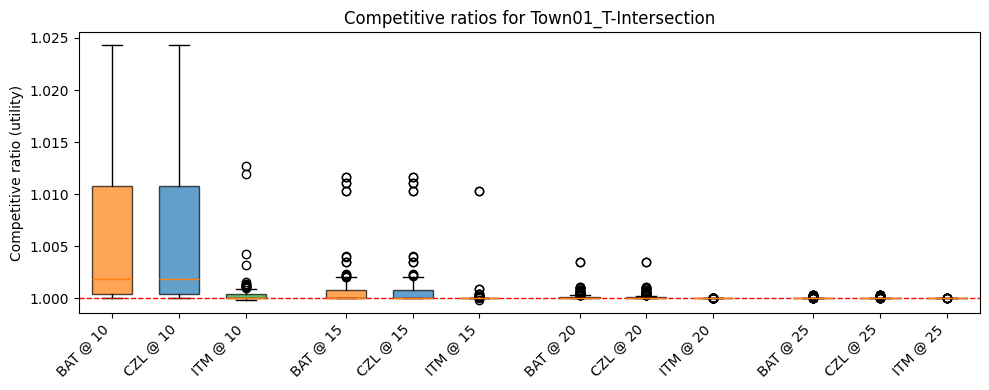

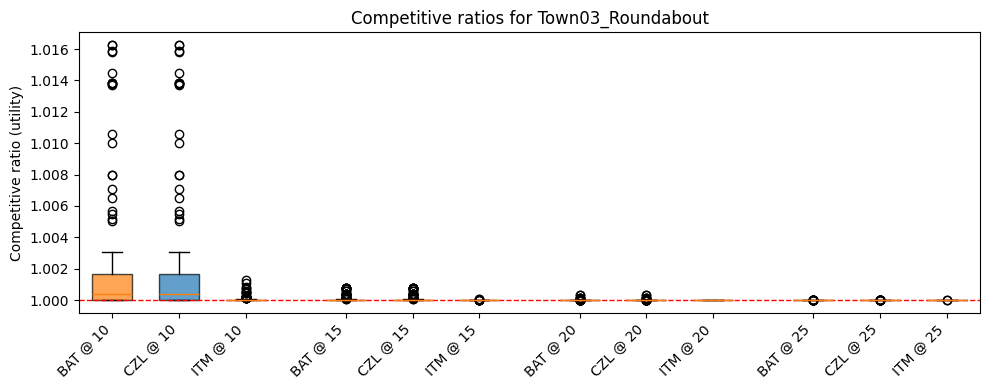

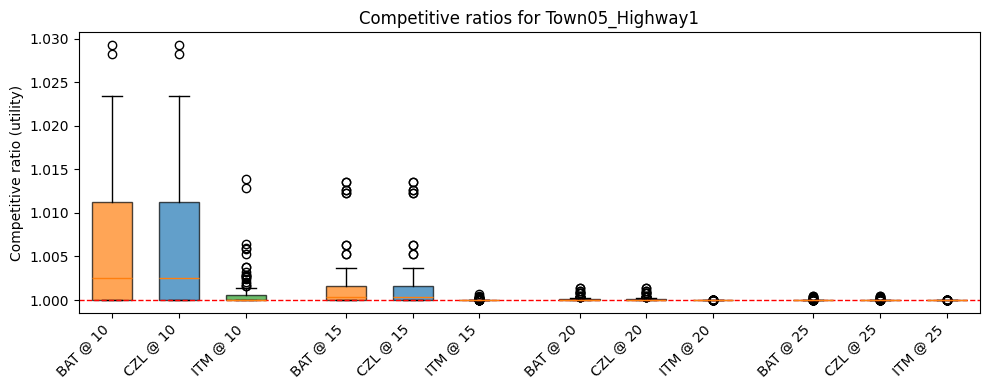

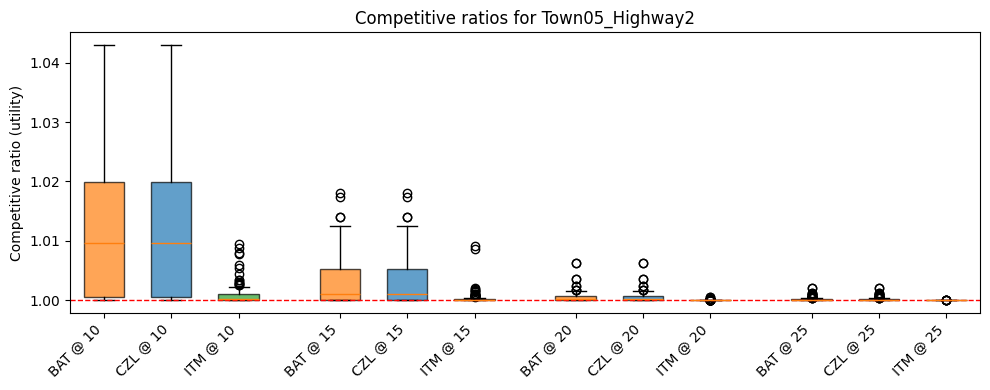

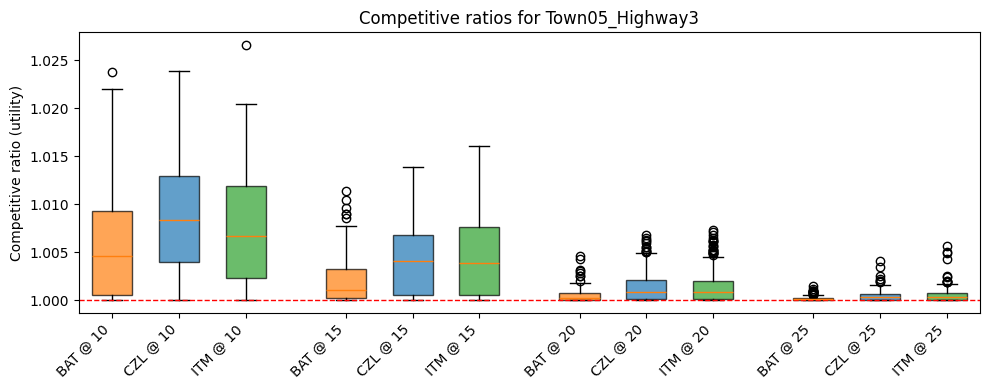

In [16]:

import matplotlib.pyplot as plt

risk_labels = {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}


def parse_meta(stem: str):
    parts = stem.split("_")
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None
    budget = None
    try:
        budget = float(parts[risk_idx - 1])
    except Exception:
        budget = None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith("iter") else parts[: risk_idx - 1]
    scenario = "_".join(scen_parts) or stem
    return scenario, budget


cr_cols = [
    "cr_czl_opt_cand",
    "cr_czl_opt_graph",
    "cr_bat_opt_cand",
    "cr_bat_opt_graph",
    "cr_itm_opt_cand",
    "cr_itm_opt_graph",
]

long_df = df_cr.melt(id_vars=["scenario"], value_vars=cr_cols, var_name="metric", value_name="cr")
long_df = long_df.dropna(subset=["cr"])
long_df["algorithm"] = long_df["metric"].str.split("_").str[1].str.upper()
long_df["offline_ref"] = long_df["metric"].str.split("_").str[-1]
meta = long_df["scenario"].apply(parse_meta)
long_df["scenario_name"] = meta.apply(lambda x: x[0])
long_df["budget"] = meta.apply(lambda x: x[1])

alg_colors = {"CZL": "#1f77b4", "BAT": "#ff7f0e", "ITM": "#2ca02c"}

for scen in sorted(long_df["scenario_name"].dropna().unique()):
    sub = long_df[long_df["scenario_name"] == scen]
    if sub.empty:
        continue
    budgets = sorted([b for b in sub["budget"].dropna().unique()])
    data = []
    positions = []
    labels = []
    label_algs = []
    pos = 1
    for b in budgets:
        for alg in sorted(sub["algorithm"].unique()):
            vals = sub[(sub["budget"] == b) & (sub["algorithm"] == alg)]["cr"].dropna()
            if vals.empty:
                continue
            data.append(vals)
            positions.append(pos)
            labels.append(f"{alg} @ {int(b) if b.is_integer() else b}")
            label_algs.append(alg)
            pos += 1
        pos += 0.5  # gap between budgets

    if not data:
        continue

    plt.figure(figsize=(10, 4))
    bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
    for patch, alg in zip(bp['boxes'], label_algs):
        patch.set_facecolor(alg_colors.get(alg, "#888888"))
        patch.set_alpha(0.7)
    plt.axhline(1.0, color="red", linestyle="--", linewidth=1)
    plt.xticks(positions, labels, rotation=45, ha="right")
    plt.ylabel("Competitive ratio (utility)")
    plt.title(f"Competitive ratios for {scen}")
    plt.tight_layout()
    plt.show()


# Candidates-based competitive ratios
Visualize competitive ratios only for candidates-based problems (offline reference = candidates opt).

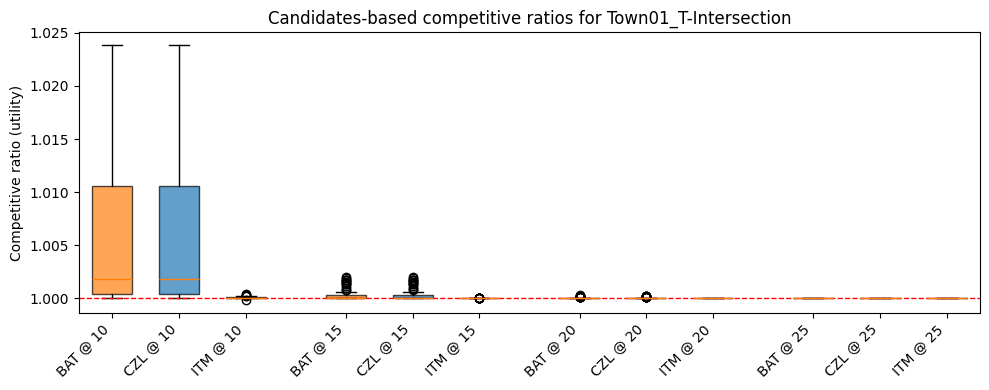

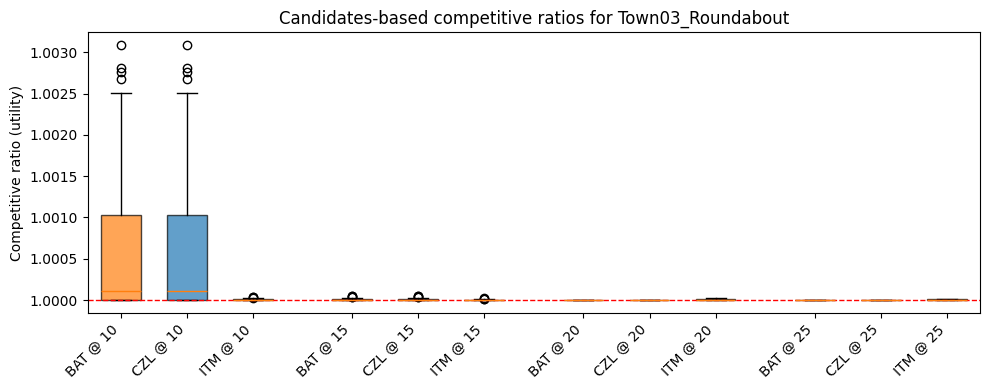

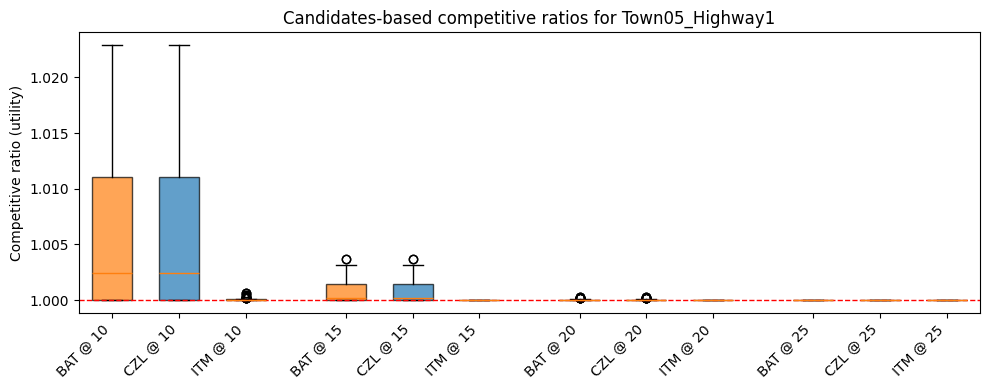

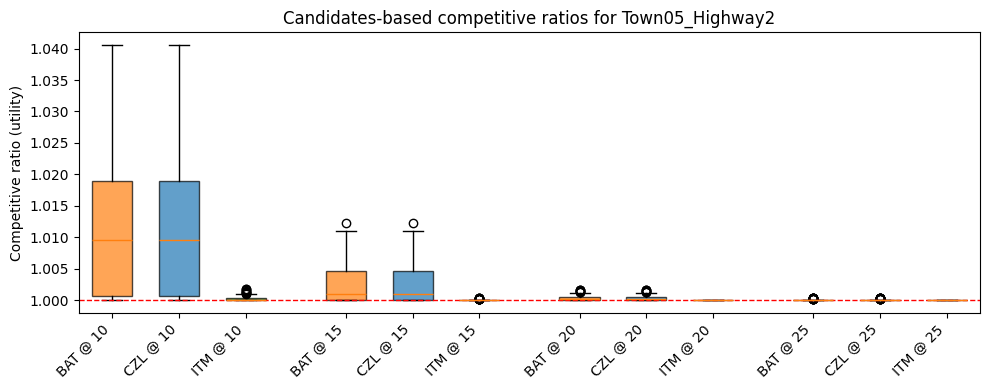

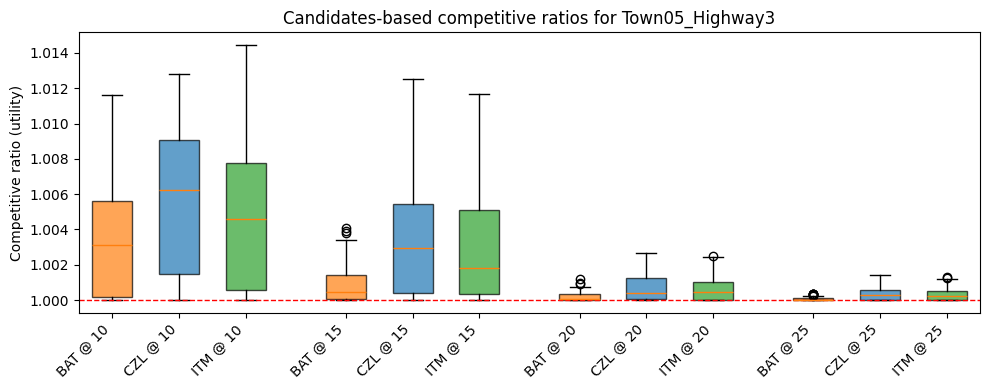

In [17]:
cand_df = long_df[long_df["offline_ref"] == "cand"].copy()
if cand_df.empty:
    print("No candidate-based competitive ratio rows found.")
else:
    colors = alg_colors if 'alg_colors' in globals() else {"CZL": "#1f77b4", "BAT": "#ff7f0e", "ITM": "#2ca02c"}
    def drop_outliers(series, k=1.5):
        if series.empty:
            return series
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - k * iqr, q3 + k * iqr
        return series[(series >= low) & (series <= high)]
    for scen in sorted(cand_df["scenario_name"].dropna().unique()):
        sub = cand_df[cand_df["scenario_name"] == scen]
        budgets = sorted([b for b in sub["budget"].dropna().unique()])
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in sorted(sub["algorithm"].unique()):
                vals = sub[(sub["budget"] == b) & (sub["algorithm"] == alg)]["cr"].dropna()
                vals = drop_outliers(vals)
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if b.is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5
        if not data:
            print(f"Skipping {scen}: no candidate-based CR values.")
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, "#888888"))
            patch.set_alpha(0.7)
        plt.axhline(1.0, color="red", linestyle="--", linewidth=1)
        plt.xticks(positions, labels, rotation=45, ha="right")
        plt.ylabel("Competitive ratio (utility)")
        plt.title(f"Candidates-based competitive ratios for {scen}")
        plt.tight_layout()
        plt.show()


# CZL vs BAT (candidates-only)
Box compare competitive ratios for CZL vs BAT using candidates-based offline reference.

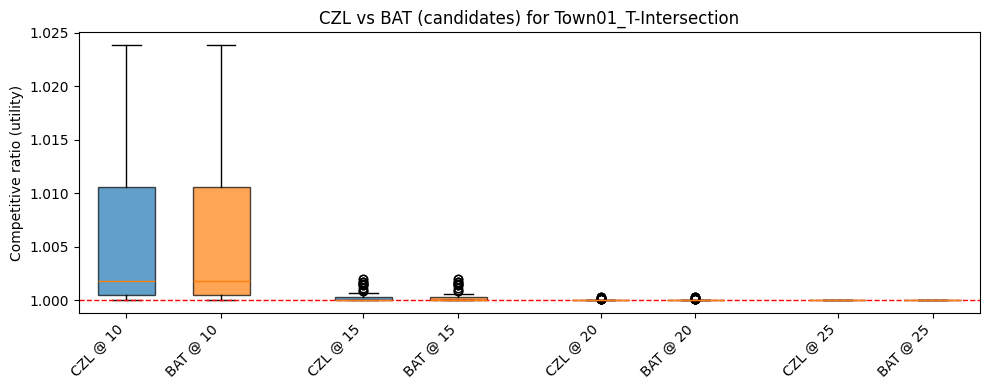

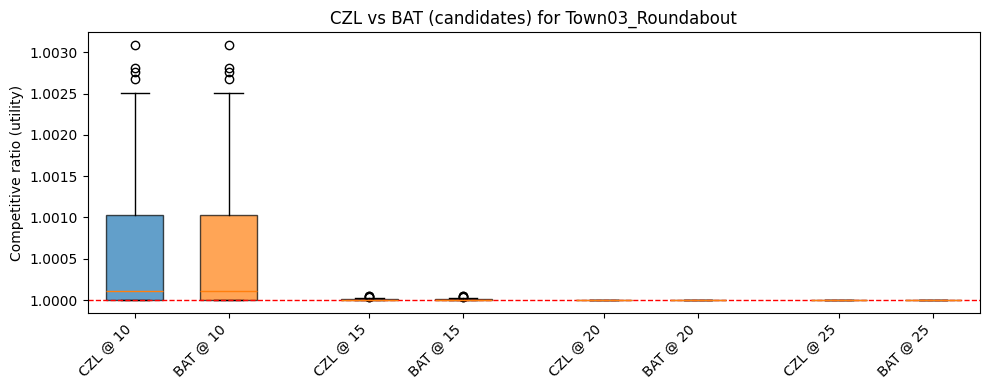

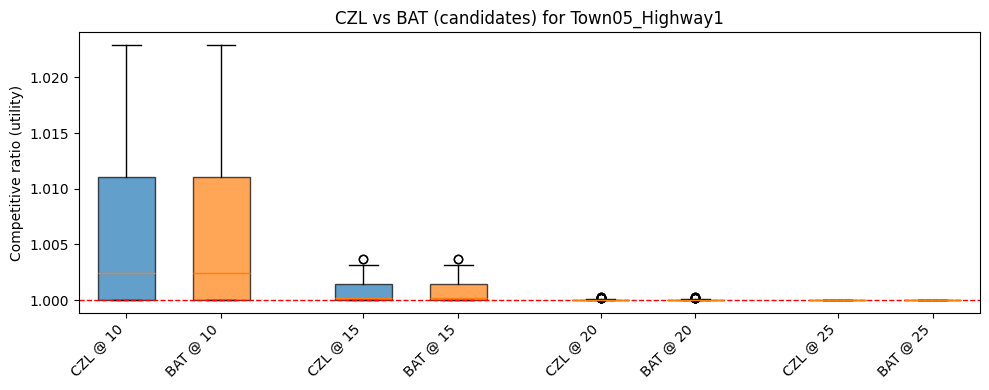

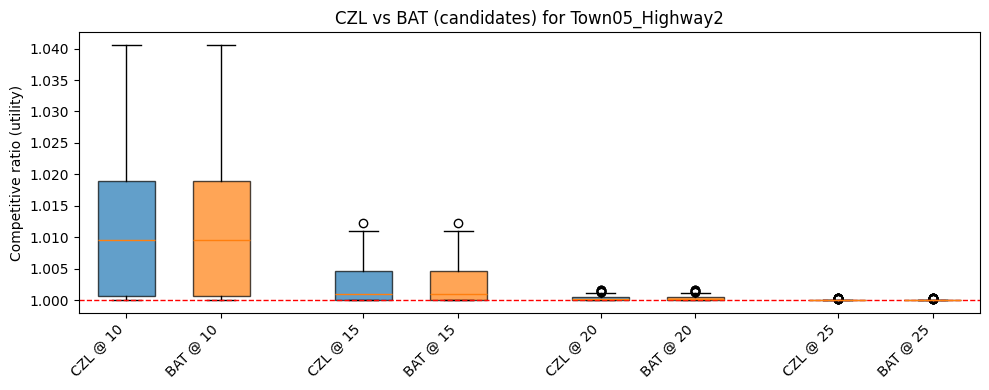

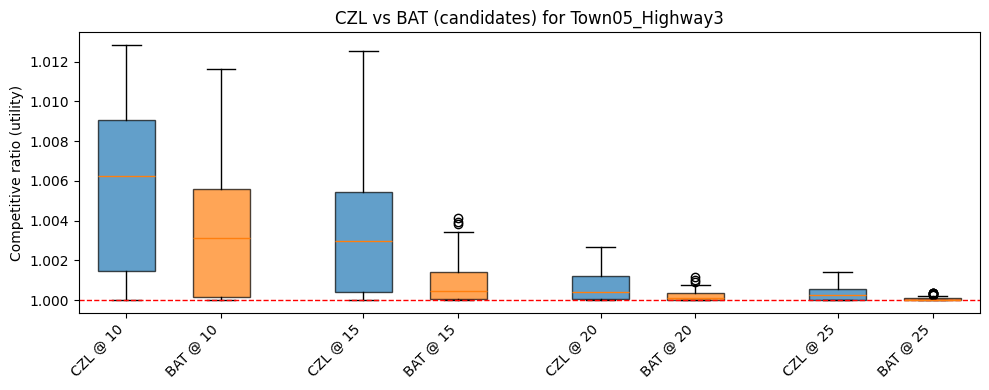

In [18]:

compare_df = long_df[(long_df['offline_ref'] == 'cand') & (long_df['algorithm'].isin(['CZL', 'BAT']))].copy()
if compare_df.empty:
    print('No candidate-based CZL/BAT rows found.')
else:
    colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e'}
    def drop_outliers(series, k=1.5):
        if series.empty:
            return series
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - k * iqr, q3 + k * iqr
        return series[(series >= lo) & (series <= hi)]
    for scen in sorted(compare_df['scenario_name'].dropna().unique()):
        sub = compare_df[compare_df['scenario_name'] == scen]
        budgets = sorted([b for b in sub['budget'].dropna().unique()])
        if not budgets:
            print(f'Skipping {scen}: no budgets found.')
            continue
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in ['CZL', 'BAT']:
                vals = sub[(sub['budget'] == b) & (sub['algorithm'] == alg)]['cr'].dropna()
                vals = drop_outliers(vals)
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if b.is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5
        if not data:
            print(f'Skipping {scen}: no CZL/BAT CR values after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, '#888888'))
            patch.set_alpha(0.7)
        plt.axhline(1.0, color='red', linestyle='--', linewidth=1)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Competitive ratio (utility)')
        plt.title(f'CZL vs BAT (candidates) for {scen}')
        plt.tight_layout()
        plt.show()


# ITM competitive ratios (candidates-only)
Box plots for ITM using candidates-based offline reference; outliers removed via IQR fence.

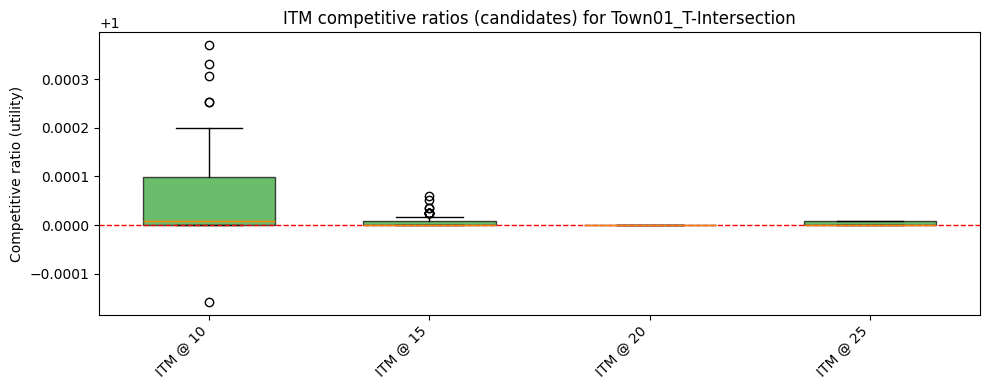

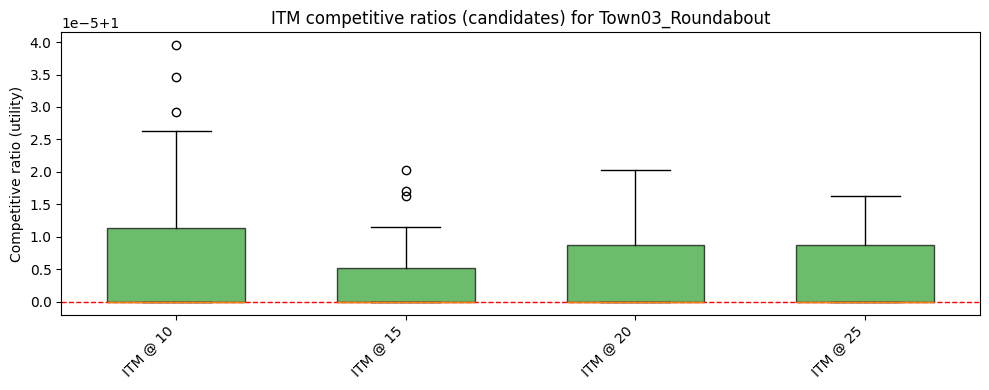

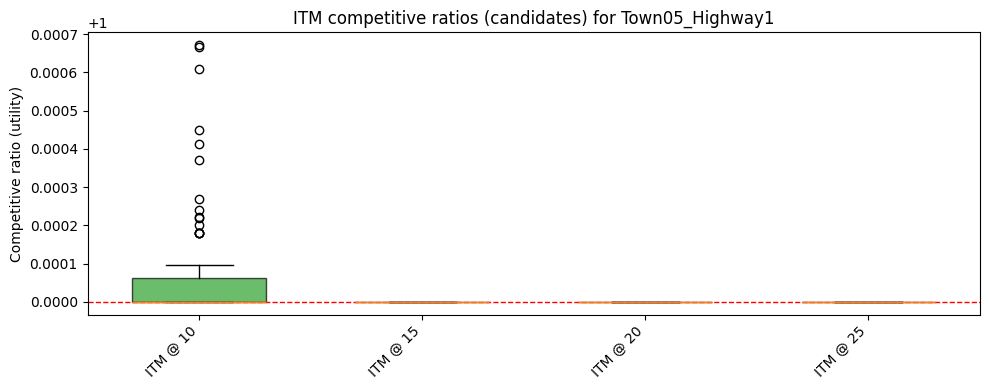

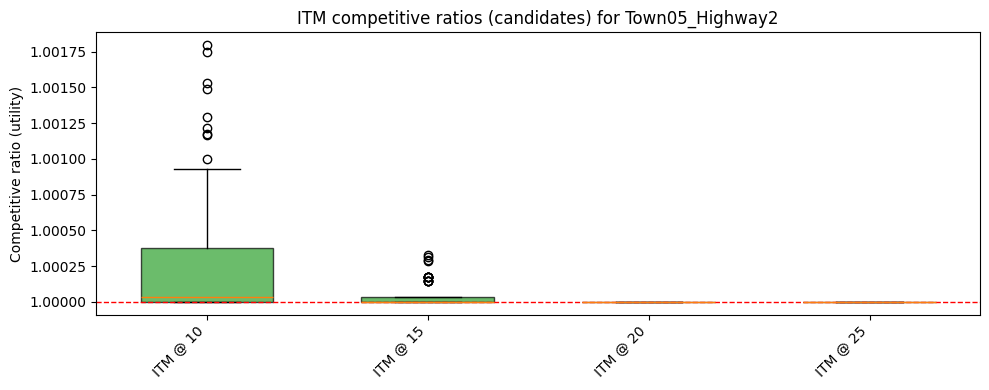

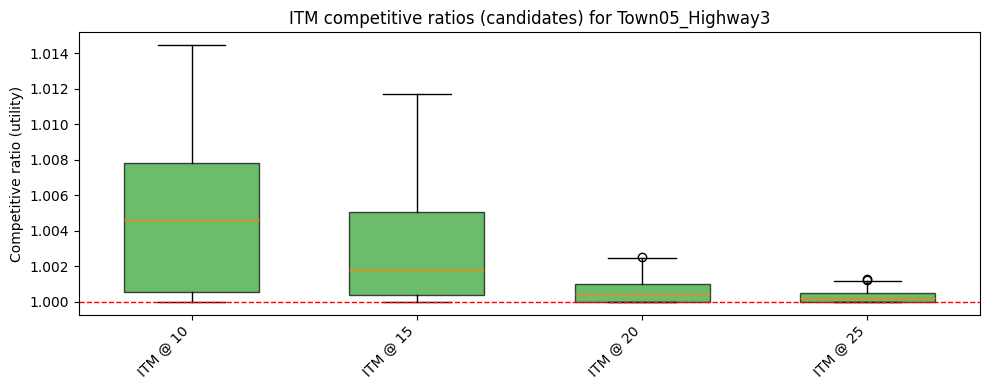

In [19]:

# ITM only, candidates-based reference
itm_df = long_df[(long_df['offline_ref'] == 'cand') & (long_df['algorithm'] == 'ITM')].copy()
if itm_df.empty:
    print('No candidate-based ITM rows found.')
else:
    color = '#2ca02c'
    def drop_outliers(series, k=1.5):
        if series.empty:
            return series
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - k * iqr, q3 + k * iqr
        return series[(series >= lo) & (series <= hi)]
    for scen in sorted(itm_df['scenario_name'].dropna().unique()):
        sub = itm_df[itm_df['scenario_name'] == scen]
        budgets = sorted([b for b in sub['budget'].dropna().unique()])
        data, positions, labels = [], [], []
        pos = 1
        for b in budgets:
            vals = sub[sub['budget'] == b]['cr'].dropna()
            vals = drop_outliers(vals)
            if vals.empty:
                continue
            data.append(vals)
            positions.append(pos)
            labels.append(f"ITM @ {int(b) if b.is_integer() else b}")
            pos += 1
        if not data:
            print(f'Skipping {scen}: no ITM CR values after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        plt.axhline(1.0, color='red', linestyle='--', linewidth=1)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Competitive ratio (utility)')
        plt.title(f'ITM competitive ratios (candidates) for {scen}')
        plt.tight_layout()
        plt.show()


# Theoretical CZL competitive ratio
Compute the bound based on candidate sets: CR_czl <= ln(rho_max / rho_min) + 2 (rho = utility / risk).

In [20]:

import math
from motion_planning.online_algorithms.thresholds import czl_thresholds

cand_files = sorted((OFFLINE_RESULTS_DIR / "problem details").glob("*_candidates.csv"))

# Reuse parse_meta/risk labels if available; otherwise define a minimal parser.
risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_meta_with_risk(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
    else:
        parts = stem.split("_")
        scen, budget = stem, None
        for i, p in enumerate(parts):
            if p.lower() in risk_labels_local and i >= 1:
                scen = "_".join(parts[: i - 1]) or stem
                try:
                    budget = float(parts[i - 1])
                except Exception:
                    budget = None
                break
    parts = stem.split("_")
    risk = next((p for p in parts[::-1] if p.lower() in risk_labels_local), None)
    return scen, budget, risk

rows = []
for f in cand_files:
    stem = f.stem.replace("_candidates", "")
    try:
        rho_min, rho_max, _ = czl_thresholds([f])
    except Exception as exc:  # safety if file is empty or risks are 0
        print(f"Skip {f.name}: {exc}")
        continue
    scen, budget, risk = _parse_meta_with_risk(stem)
    bound = math.log(rho_max / rho_min) + 2
    rows.append({
        "file": f.name,
        "scenario": scen,
        "budget": budget,
        "risk": risk,
        "rho_min": rho_min,
        "rho_max": rho_max,
        "cr_czl_theoretical": bound,
    })

if not rows:
    print("No candidate files produced a theoretical bound.")
else:
    df_theory = pd.DataFrame(rows)
    display(df_theory.sort_values(["scenario", "budget", "risk"]))


,file,scenario,budget,risk,rho_min,rho_max,cr_czl_theoretical
0,iter10_Town01_T-Intersection_10_high_5_candida...,Town01_T-Intersection,10.0,high,192.008739,2157.381268,4.419110
3,iter10_Town01_T-Intersection_10_very_high_5_ca...,Town01_T-Intersection,10.0,high,183.947869,78783.161613,8.059802
80,iter11_Town01_T-Intersection_10_high_5_candida...,Town01_T-Intersection,10.0,high,197.262047,1161.662658,3.773075
83,iter11_Town01_T-Intersection_10_very_high_5_ca...,Town01_T-Intersection,10.0,high,195.309233,1745.339942,4.190121
160,iter12_Town01_T-Intersection_10_high_5_candida...,Town01_T-Intersection,10.0,high,227.404596,1607.292468,3.955576
...,...,...,...,...,...,...,...
1278,iter5_Town05_Highway3_25_medium_8_candidates.csv,Town05_Highway3,25.0,medium,190.962405,95357.423550,8.213311
1358,iter6_Town05_Highway3_25_medium_8_candidates.csv,Town05_Highway3,25.0,medium,258.614931,93774.922124,7.893313
1438,iter7_Town05_Highway3_25_medium_8_candidates.csv,Town05_Highway3,25.0,medium,317.639217,95527.991242,7.706258
1518,iter8_Town05_Highway3_25_medium_8_candidates.csv,Town05_Highway3,25.0,medium,195.025172,94896.268668,8.187411


In [21]:
df_theory["cr_czl_theoretical"].max()

8.749600799276196

# Risk consumption (total risk)
Box plot of total risk consumed by CZL, BAT, and ITM solutions at a chosen budget (example: 5).

In [22]:

import math

# Change this to inspect a different budget
budget_target = 5
risk_cols = {
    'CZL': 'online_czl.total_risk',
    'BAT': 'online_bat.total_risk',
    'ITM': 'online_itm.total_risk',
}

# Use existing parse_meta if present; otherwise fall back to a minimal parser
risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_budget(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
        return scen, budget
    parts = stem.split('_')
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
    scenario = '_'.join(scen_parts) or stem
    try:
        budget = float(parts[risk_idx - 1])
    except Exception:
        budget = None
    return scenario, budget

rows = []
for _, row in df_cr.iterrows():
    scen, bud = _parse_budget(row['scenario'])
    if bud is None or bud != budget_target:
        continue
    for alg, col in risk_cols.items():
        val = row.get(col)
        if val is None or pd.isna(val):
            continue
        rows.append({
            'scenario': scen,
            'budget': bud,
            'algorithm': alg,
            'total_risk': float(val),
        })

if not rows:
    print(f'No total risk rows found for budget={budget_target}.')
else:
    risk_df = pd.DataFrame(rows)
    plt.figure(figsize=(6, 4))
    algs = ['CZL', 'BAT', 'ITM']
    data = [risk_df[risk_df['algorithm'] == alg]['total_risk'] for alg in algs]
    bp = plt.boxplot(data, labels=algs, widths=0.6, patch_artist=True)
    colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e', 'ITM': '#2ca02c'}
    for patch, alg in zip(bp['boxes'], algs):
        patch.set_facecolor(colors.get(alg, '#888888'))
        patch.set_alpha(0.7)
    plt.axhline(budget_target, color='red', linestyle='--', linewidth=1, label='budget')
    plt.ylabel('Total risk')
    plt.title(f'Total risk at budget={budget_target}')
    plt.legend()
    plt.tight_layout()
    plt.show()


No total risk rows found for budget=5.


# Risk consumption by scenario/budget
Box plots of total risk for CZL, BAT, and ITM across all scenarios and budgets (candidates-based runs).

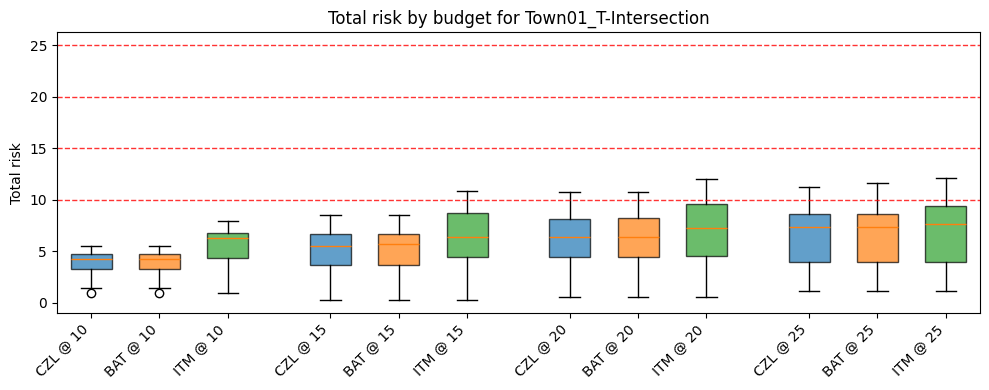

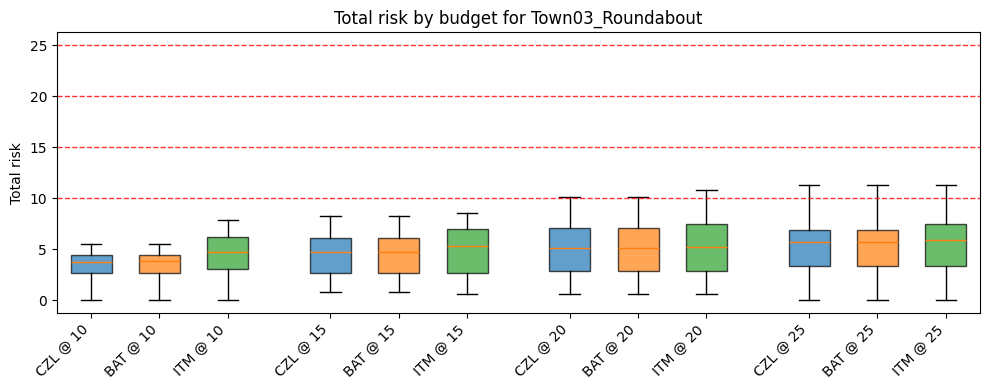

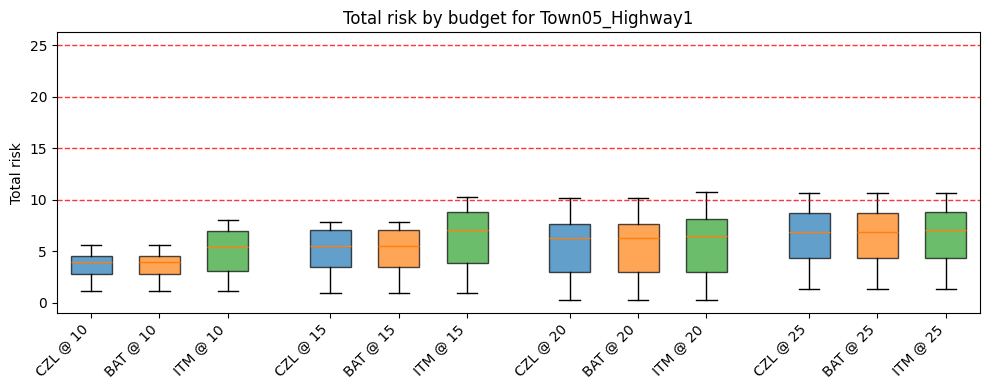

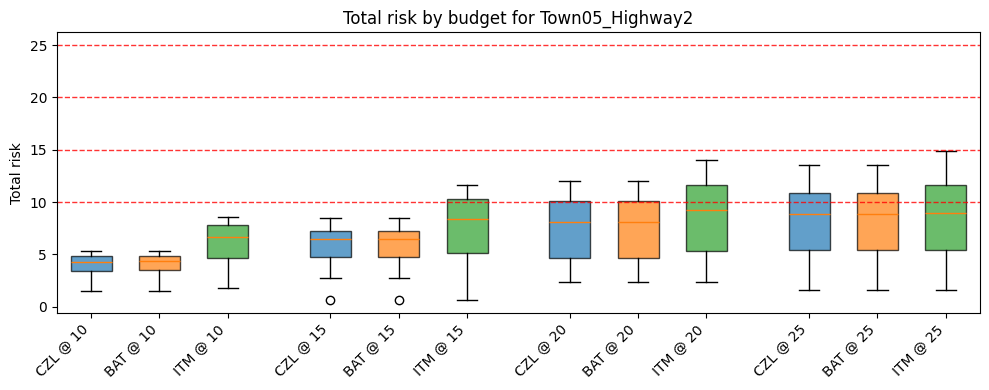

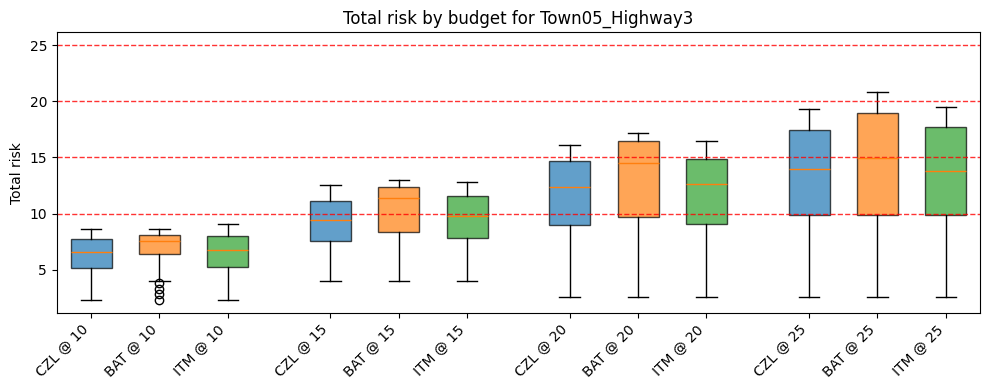

In [23]:

import math

risk_cols = {
    'CZL': 'online_czl.total_risk',
    'BAT': 'online_bat.total_risk',
    'ITM': 'online_itm.total_risk',
}
colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e', 'ITM': '#2ca02c'}

risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_meta_risk(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
    else:
        parts = stem.split('_')
        risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
        if risk_idx is None or risk_idx < 1:
            return stem, None
        scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
        scen = '_'.join(scen_parts) or stem
        try:
            budget = float(parts[risk_idx - 1])
        except Exception:
            budget = None
    return scen, budget

records = []
for _, r in df_cr.iterrows():
    scen, bud = _parse_meta_risk(r['scenario'])
    if bud is None:
        continue
    for alg, col in risk_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        records.append({
            'scenario': scen,
            'budget': bud,
            'algorithm': alg,
            'total_risk': float(val),
        })

if not records:
    print('No total risk rows found.')
else:
    risk_df = pd.DataFrame(records)
    for scen in sorted(risk_df['scenario'].dropna().unique()):
        sub = risk_df[risk_df['scenario'] == scen]
        budgets = sorted(sub['budget'].dropna().unique())
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in ['CZL', 'BAT', 'ITM']:
                vals = sub[(sub['budget'] == b) & (sub['algorithm'] == alg)]['total_risk'].dropna()
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if float(b).is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5  # gap between budgets
        if not data:
            print(f'Skipping {scen}: no risk rows after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, '#888888'))
            patch.set_alpha(0.7)
        for b in budgets:
            plt.axhline(b, color='red', linestyle='--', linewidth=1, alpha=0.8)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Total risk')
        plt.title(f'Total risk by budget for {scen}')
        plt.tight_layout()
        plt.show()


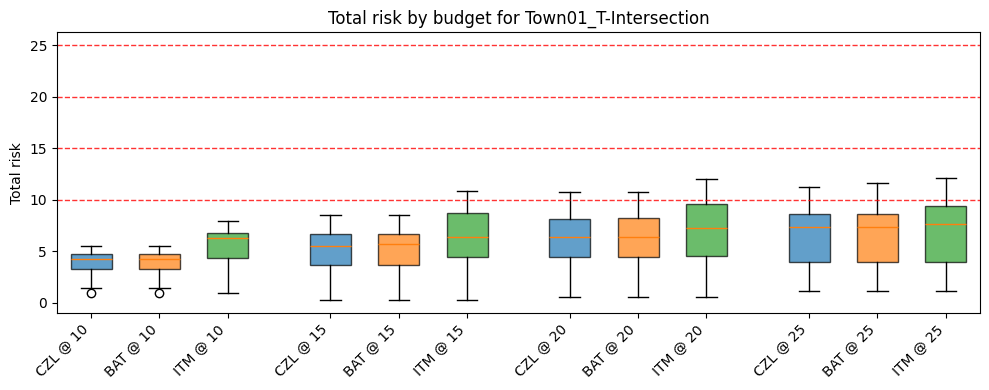

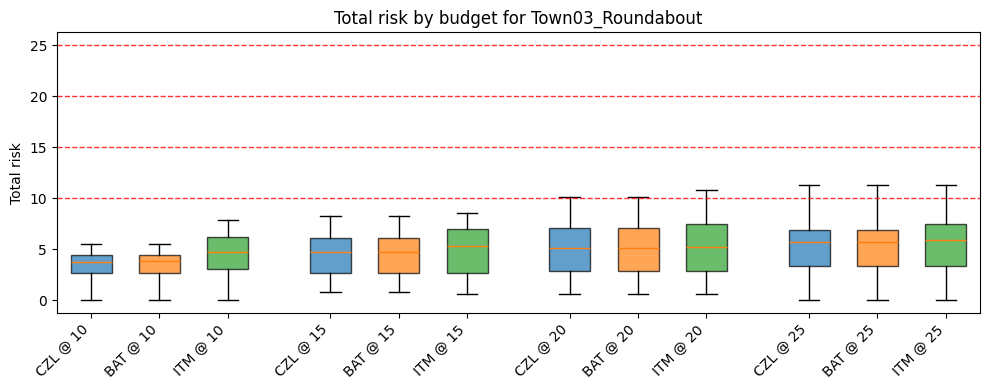

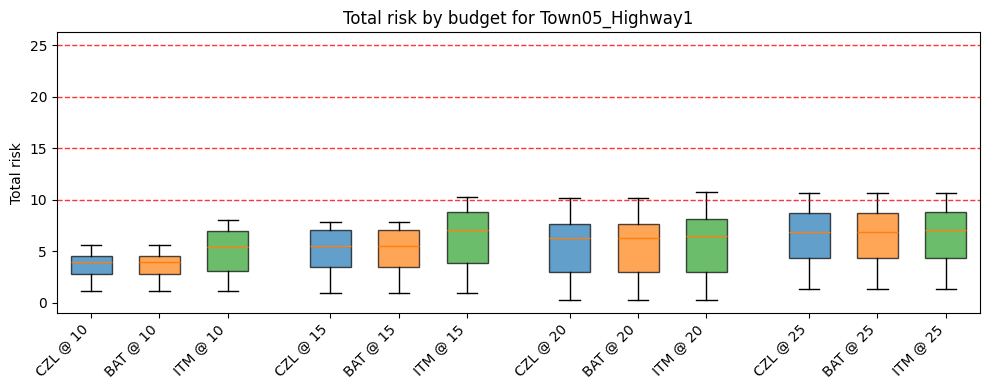

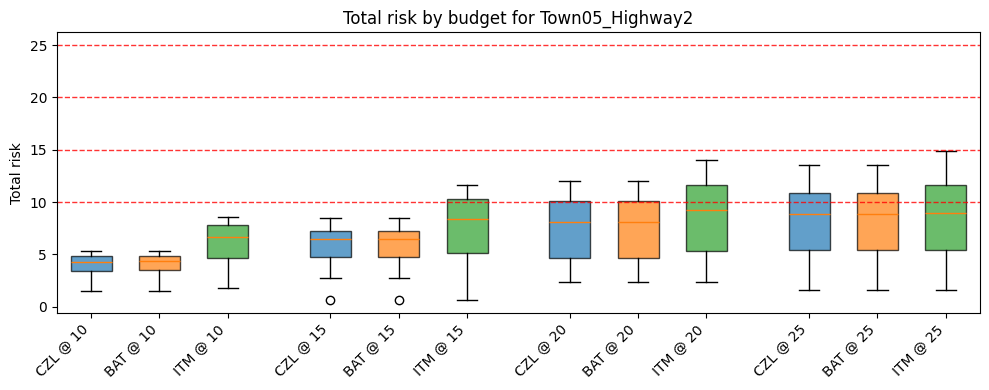

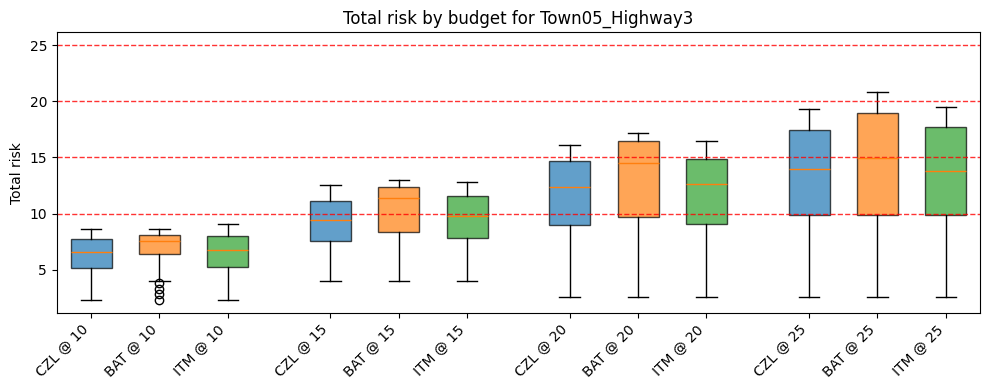

In [24]:

import matplotlib.pyplot as plt

risk_labels = {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}


def parse_meta(stem: str):
    parts = stem.split("_")
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None
    budget = None
    try:
        budget = float(parts[risk_idx - 1])
    except Exception:
        budget = None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith("iter") else parts[: risk_idx - 1]
    scenario = "_".join(scen_parts) or stem
    return scenario, budget


cr_cols = [
    "cr_czl_opt_cand",
    "cr_czl_opt_graph",
    "cr_bat_opt_cand",
    "cr_bat_opt_graph",
    "cr_itm_opt_cand",
    "cr_itm_opt_graph",
]

long_df = df_cr.melt(id_vars=["scenario"], value_vars=cr_cols, var_name="metric", value_name="cr")
long_df = long_df.dropna(subset=["cr"])
long_df["algorithm"] = long_df["metric"].str.split("_").str[1].str.upper()
long_df["offline_ref"] = long_df["metric"].str.split("_").str[-1]
meta = long_df["scenario"].apply(parse_meta)
long_df["scenario_name"] = meta.apply(lambda x: x[0])
long_df["budget"] = meta.apply(lambda x: x[1])

alg_colors = {"CZL": "#1f77b4", "BAT": "#ff7f0e", "ITM": "#2ca02c"}



import math

risk_cols = {
    'CZL': 'online_czl.total_risk',
    'BAT': 'online_bat.total_risk',
    'ITM': 'online_itm.total_risk',
}
colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e', 'ITM': '#2ca02c'}

risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_meta_risk(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
    else:
        parts = stem.split('_')
        risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
        if risk_idx is None or risk_idx < 1:
            return stem, None
        scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
        scen = '_'.join(scen_parts) or stem
        try:
            budget = float(parts[risk_idx - 1])
        except Exception:
            budget = None
    return scen, budget

records = []
for _, r in df_cr.iterrows():
    scen, bud = _parse_meta_risk(r['scenario'])
    if bud is None:
        continue
    for alg, col in risk_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        records.append({
            'scenario': scen,
            'budget': bud,
            'algorithm': alg,
            'total_risk': float(val),
        })

if not records:
    print('No total risk rows found.')
else:
    risk_df = pd.DataFrame(records)
    for scen in sorted(risk_df['scenario'].dropna().unique()):
        sub = risk_df[risk_df['scenario'] == scen]
        budgets = sorted(sub['budget'].dropna().unique())
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in ['CZL', 'BAT', 'ITM']:
                vals = sub[(sub['budget'] == b) & (sub['algorithm'] == alg)]['total_risk'].dropna()
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if float(b).is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5  # gap between budgets
        if not data:
            print(f'Skipping {scen}: no risk rows after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, '#888888'))
            patch.set_alpha(0.7)
        for b in budgets:
            plt.axhline(b, color='red', linestyle='--', linewidth=1, alpha=0.8)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Total risk')
        plt.title(f'Total risk by budget for {scen}')
        plt.tight_layout()
        plt.show()


## Competitive ratios: ORB variants vs offline graph opt
Compute CRs for BAT-ORB, CZL-ORB, and ITM-ORB using the offline graph-based optimal solutions (solution edges) as the reference.

In [25]:

# Competitive ratios of ORB variants vs offline graph-based optima
offline_graph_map = {f.stem.replace("_offline_graph_solution_edges", ""): f for f in offline_graph}
online_graph_map = {f.stem.replace("_online_ITM-ORB", ""): f for f in online_graph}

online_cand_map = {}
for f in online_cand:
    stem = f.stem
    base, alg = stem.split("_online_", 1) if "_online_" in stem else (stem, "unknown")
    online_cand_map.setdefault(alg, {})[base] = f

alg_sources = {
    "BAT-ORB": online_cand_map.get("BAT-ORB", {}),
    "CZL-ORB": online_cand_map.get("CZL-ORB", {}),
    "ITM-ORB": online_graph_map,
}

records_orb_graph = []
for base, off_path in offline_graph_map.items():
    df_off = pd.read_csv(off_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    for alg, on_map in alg_sources.items():
        on_path = on_map.get(base)
        if on_path is None:
            continue
        df_on = pd.read_csv(on_path)
        on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
        cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
        records_orb_graph.append({
            "scenario": base,
            "algorithm": alg,
            "offline_file": off_path.name,
            "online_file": on_path.name,
            "offline_utility": off_util,
            "online_utility": on_util,
            "cr_utility": cr,
        })

df_orb_graph_cr = pd.DataFrame(records_orb_graph)
display(df_orb_graph_cr)


,scenario,algorithm,offline_file,online_file,offline_utility,online_utility,cr_utility
0,iter10_Town01_T-Intersection_10_high_5,BAT-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1964.976942,1940.256165,1.012741
1,iter10_Town01_T-Intersection_10_high_5,CZL-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1964.976942,1940.256165,1.012741
2,iter10_Town01_T-Intersection_10_high_5,ITM-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,1964.976942,1962.236666,1.001397
3,iter10_Town01_T-Intersection_10_low_5,BAT-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_B...,1965.044177,1965.044177,1.000000
4,iter10_Town01_T-Intersection_10_low_5,CZL-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_C...,1965.044177,1965.044177,1.000000
...,...,...,...,...,...,...,...
4795,iter9_Town05_Highway3_25_medium_8,CZL-ORB,iter9_Town05_Highway3_25_medium_8_offline_grap...,iter9_Town05_Highway3_25_medium_8_online_CZL-O...,4682.140293,4681.390654,1.000160
4796,iter9_Town05_Highway3_25_medium_8,ITM-ORB,iter9_Town05_Highway3_25_medium_8_offline_grap...,iter9_Town05_Highway3_25_medium_8_online_ITM-O...,4682.140293,4681.710327,1.000092
4797,iter9_Town05_Highway3_25_very_high_8,BAT-ORB,iter9_Town05_Highway3_25_very_high_8_offline_g...,iter9_Town05_Highway3_25_very_high_8_online_BA...,4682.056855,4678.110352,1.000844
4798,iter9_Town05_Highway3_25_very_high_8,CZL-ORB,iter9_Town05_Highway3_25_very_high_8_offline_g...,iter9_Town05_Highway3_25_very_high_8_online_CZ...,4682.056855,4672.929787,1.001953


### Summary stats by algorithm
Quick descriptive stats for the computed competitive ratios grouped by algorithm.

In [26]:

if df_orb_graph_cr.empty:
    print("No overlapping offline graph optima and online ORB solutions found.")
else:
    display(df_orb_graph_cr.groupby("algorithm")["cr_utility"].describe())


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,1600.0,1.002252,0.005322,1.0,1.0,1.000056,1.001230,1.042988
CZL-ORB,1600.0,1.002541,0.005571,1.0,1.0,1.000078,1.001611,1.042988
ITM-ORB,1600.0,1.001049,0.003097,1.0,1.0,1.000000,1.000236,1.026604


## Per-scenario/budget/risk competitive ratios by algorithm
Break out CRs for CZL-ORB, BAT-ORB, and ITM-ORB using offline graph optimal (solution edges) as reference. Expect 5 scenarios x 4 budgets x 4 risk labels = 80 subsets.

In [27]:

if df_orb_graph_cr.empty:
    print("df_orb_graph_cr is empty; run the ORB vs offline cell above first.")
else:
    # Extract scenario name, budget, and risk label from the stem
    risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

    def _parse_meta_full(stem: str):
        parts = stem.split("_")
        risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
        if risk_idx is None or risk_idx < 1:
            return stem, None, None
        scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith("iter") else parts[: risk_idx - 1]
        scenario = "_".join(scen_parts) or stem
        try:
            budget_val = float(parts[risk_idx - 1])
        except Exception:
            budget_val = None
        risk_label = parts[risk_idx]
        return scenario, budget_val, risk_label

    df_orb_graph_cr = df_orb_graph_cr.copy()
    meta = df_orb_graph_cr["scenario"].apply(_parse_meta_full)
    df_orb_graph_cr["scenario_name"] = meta.apply(lambda x: x[0])
    df_orb_graph_cr["budget"] = meta.apply(lambda x: x[1])
    df_orb_graph_cr["risk_label"] = meta.apply(lambda x: x[2])
    df_orb_graph_cr["risk_label_norm"] = df_orb_graph_cr["risk_label"].str.lower()

    alg_interest = ["CZL-ORB", "BAT-ORB", "ITM-ORB"]
    df_orb_graph_cr = df_orb_graph_cr[df_orb_graph_cr["algorithm"].isin(alg_interest)]

    scenarios = sorted(df_orb_graph_cr["scenario_name"].dropna().unique())
    budgets = sorted(df_orb_graph_cr["budget"].dropna().unique())
    risks = sorted(df_orb_graph_cr["risk_label_norm"].dropna().unique())

    per_combo_frames = {}
    for scen in scenarios:
        for bud in budgets:
            for risk in risks:
                sub = df_orb_graph_cr[
                    (df_orb_graph_cr["scenario_name"] == scen)
                    & (df_orb_graph_cr["budget"] == bud)
                    & (df_orb_graph_cr["risk_label_norm"] == risk)
                ]
                per_combo_frames[(scen, bud, risk)] = sub

    expected = len(scenarios) * len(budgets) * len(risks)
    print(f"Built {len(per_combo_frames)} combo DataFrames (expected {expected}).")
    print(f"Scenarios={len(scenarios)}, budgets={len(budgets)}, risks={len(risks)}")


Built 80 combo DataFrames (expected 80).
Scenarios=5, budgets=4, risks=4


### Describe per-combo frames (by algorithm)
For each (scenario, budget, risk) subset, show CR descriptive stats grouped by algorithm.

In [28]:

if 'per_combo_frames' not in globals() or not per_combo_frames:
    print("No per-combo frames available; run the generation cell first.")
else:
    per_combo_describe = {}
    for key, sub in per_combo_frames.items():
        if sub.empty:
            print(f"Describe for combo {key}: empty (no matching runs).")
            continue
        desc = sub.groupby("algorithm")["cr_utility"].describe()
        per_combo_describe[key] = desc
        print(f"Describe for combo {key} (rows={len(sub)}):")
        display(desc)


Describe for combo ('Town01_T-Intersection', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.006517,0.005295,1.000563,1.001926,1.004473,1.011841,1.016455
CZL-ORB,20.0,1.006517,0.005295,1.000563,1.001926,1.004473,1.011841,1.016455
ITM-ORB,20.0,1.001354,0.002838,1.000009,1.000163,1.000512,1.001125,1.012734


Describe for combo ('Town01_T-Intersection', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000901,0.002341,1.0,1.0,1.000126,1.000618,1.010300
CZL-ORB,20.0,1.000901,0.002341,1.0,1.0,1.000126,1.000618,1.010300
ITM-ORB,20.0,1.000013,0.000027,1.0,1.0,1.000009,1.000011,1.000122


Describe for combo ('Town01_T-Intersection', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001481,0.002594,1.000009,1.000285,1.000720,1.001251,1.011700
CZL-ORB,20.0,1.001481,0.002594,1.000009,1.000285,1.000720,1.001251,1.011700
ITM-ORB,20.0,1.000145,0.000335,1.000000,1.000000,1.000013,1.000129,1.001354


Describe for combo ('Town01_T-Intersection', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.011766,0.006474,1.002657,1.006096,1.011965,1.013450,1.024313
CZL-ORB,20.0,1.011766,0.006474,1.002657,1.006096,1.011965,1.013450,1.024313
ITM-ORB,20.0,1.000727,0.000316,1.000253,1.000464,1.000722,1.000909,1.001299


Describe for combo ('Town01_T-Intersection', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001583,0.003238,1.0,1.000104,1.000144,1.001183,1.011065
CZL-ORB,20.0,1.001583,0.003237,1.0,1.000104,1.000144,1.001183,1.011065
ITM-ORB,20.0,1.000018,0.000033,1.0,1.000000,1.000000,1.000026,1.000131


Describe for combo ('Town01_T-Intersection', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.347760e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,1.922478e-06,1.0,1.0,1.0,1.000000,1.000009
ITM-ORB,20.0,1.000002,3.819796e-06,1.0,1.0,1.0,1.000002,1.000009


Describe for combo ('Town01_T-Intersection', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000052,0.000127,1.0,1.0,1.000009,1.000019,1.000500
CZL-ORB,20.0,1.000061,0.000150,1.0,1.0,1.000009,1.000026,1.000622
ITM-ORB,20.0,1.000599,0.002292,1.0,1.0,1.000009,1.000028,1.010291


Describe for combo ('Town01_T-Intersection', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001879,0.002466,1.000206,1.000717,1.001411,1.001786,1.011618
CZL-ORB,20.0,1.001880,0.002466,1.000206,1.000717,1.001411,1.001786,1.011618
ITM-ORB,20.0,1.000088,0.000104,1.000000,1.000006,1.000064,1.000124,1.000392


Describe for combo ('Town01_T-Intersection', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000250,0.000366,1.0,1.0,1.000121,1.000278,1.001096
CZL-ORB,20.0,1.000250,0.000367,1.0,1.0,1.000121,1.000278,1.001096
ITM-ORB,20.0,1.000002,0.000004,1.0,1.0,1.000000,1.000000,1.000009


Describe for combo ('Town01_T-Intersection', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.440816e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,1.440816e-16,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000003,4.911851e-06,1.0,1.0,1.0,1.000002,1.000017


Describe for combo ('Town01_T-Intersection', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000047,0.000091,1.0,1.0,1.0,1.000037,1.000305
CZL-ORB,20.0,1.000047,0.000092,1.0,1.0,1.0,1.000037,1.000314
ITM-ORB,20.0,1.000003,0.000004,1.0,1.0,1.0,1.000009,1.000009


Describe for combo ('Town01_T-Intersection', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000403,0.000778,1.0,1.000009,1.000129,1.000495,1.003527
CZL-ORB,20.0,1.000403,0.000779,1.0,1.000009,1.000129,1.000495,1.003536
ITM-ORB,20.0,1.000006,0.000017,1.0,1.000000,1.000000,1.000000,1.000068


Describe for combo ('Town01_T-Intersection', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000019,0.000058,1.0,1.0,1.0,1.000002,1.000244
CZL-ORB,20.0,1.000019,0.000058,1.0,1.0,1.0,1.000002,1.000244
ITM-ORB,20.0,1.000004,0.000008,1.0,1.0,1.0,1.000002,1.000026


Describe for combo ('Town01_T-Intersection', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.273513e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,1.273513e-16,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000005,6.504775e-06,1.0,1.0,1.0,1.000009,1.000026


Describe for combo ('Town01_T-Intersection', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000019,0.000059,1.0,1.0,1.0,1.000000,1.000237
CZL-ORB,20.0,1.000019,0.000059,1.0,1.0,1.0,1.000000,1.000237
ITM-ORB,20.0,1.000005,0.000008,1.0,1.0,1.0,1.000009,1.000026


Describe for combo ('Town01_T-Intersection', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000084,0.000135,1.0,1.0,1.0,1.000124,1.000367
CZL-ORB,20.0,1.000084,0.000136,1.0,1.0,1.0,1.000124,1.000375
ITM-ORB,20.0,1.000001,0.000003,1.0,1.0,1.0,1.000000,1.000009


Describe for combo ('Town03_Roundabout', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.003977,0.005266,1.000041,1.000437,1.001195,1.005312,1.016248
CZL-ORB,20.0,1.003977,0.005266,1.000041,1.000437,1.001195,1.005312,1.016248
ITM-ORB,20.0,1.000163,0.000330,1.000000,1.000014,1.000023,1.000159,1.001305


Describe for combo ('Town03_Roundabout', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000023,0.000088,1.0,1.0,1.0,1.000000,1.000392
CZL-ORB,20.0,1.000024,0.000087,1.0,1.0,1.0,1.000000,1.000392
ITM-ORB,20.0,1.000003,0.000007,1.0,1.0,1.0,1.000001,1.000024


Describe for combo ('Town03_Roundabout', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000187,0.000347,1.0,1.000011,1.000035,1.000173,1.001349
CZL-ORB,20.0,1.000189,0.000350,1.0,1.000011,1.000035,1.000173,1.001349
ITM-ORB,20.0,1.000039,0.000058,1.0,1.000006,1.000011,1.000040,1.000198


Describe for combo ('Town03_Roundabout', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.003625,0.004452,1.000603,1.001213,1.001821,1.002944,1.016258
CZL-ORB,20.0,1.003625,0.004452,1.000603,1.001213,1.001821,1.002944,1.016258
ITM-ORB,20.0,1.000213,0.000278,1.000000,1.000021,1.000160,1.000208,1.001065


Describe for combo ('Town03_Roundabout', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000162,0.000255,1.0,1.0,1.000011,1.000269,1.000788
CZL-ORB,20.0,1.000162,0.000255,1.0,1.0,1.000011,1.000269,1.000788
ITM-ORB,20.0,1.000005,0.000010,1.0,1.0,1.000000,1.000009,1.000040


Describe for combo ('Town03_Roundabout', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,7.641079e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,7.641079e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000003,5.676453e-06,1.0,1.0,1.0,1.000001,1.000023


Describe for combo ('Town03_Roundabout', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000007,0.000015,1.0,1.0,1.0,1.000011,1.000054
CZL-ORB,20.0,1.000007,0.000015,1.0,1.0,1.0,1.000011,1.000054
ITM-ORB,20.0,1.000005,0.000008,1.0,1.0,1.0,1.000006,1.000035


Describe for combo ('Town03_Roundabout', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000173,0.000252,1.0,1.000009,1.000040,1.000233,1.000802
CZL-ORB,20.0,1.000173,0.000252,1.0,1.000009,1.000040,1.000233,1.000802
ITM-ORB,20.0,1.000006,0.000007,1.0,1.000000,1.000005,1.000011,1.000024


Describe for combo ('Town03_Roundabout', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000001,0.000003,1.0,1.0,1.000000,1.000000,1.000011
CZL-ORB,20.0,1.000001,0.000003,1.0,1.0,1.000000,1.000000,1.000011
ITM-ORB,20.0,1.000006,0.000006,1.0,1.0,1.000007,1.000011,1.000016


Describe for combo ('Town03_Roundabout', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,6.238915e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,6.238915e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000003,5.432920e-06,1.0,1.0,1.0,1.000002,1.000016


Describe for combo ('Town03_Roundabout', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000008,0.000037,1.0,1.0,1.0,1.000000,1.000163
CZL-ORB,20.0,1.000008,0.000037,1.0,1.0,1.0,1.000000,1.000163
ITM-ORB,20.0,1.000005,0.000007,1.0,1.0,1.0,1.000009,1.000020


Describe for combo ('Town03_Roundabout', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000026,0.000076,1.0,1.0,1.0,1.00001,1.000314
CZL-ORB,20.0,1.000026,0.000076,1.0,1.0,1.0,1.00001,1.000314
ITM-ORB,20.0,1.000002,0.000004,1.0,1.0,1.0,1.00000,1.000011


Describe for combo ('Town03_Roundabout', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,5.695324e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,5.695324e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000003,4.901285e-06,1.0,1.0,1.0,1.000009,1.000011


Describe for combo ('Town03_Roundabout', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,6.738798e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,6.738798e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000002,3.841724e-06,1.0,1.0,1.0,1.000002,1.000009


Describe for combo ('Town03_Roundabout', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,7.204078e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,7.204078e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000005,7.132807e-06,1.0,1.0,1.0,1.000011,1.000023


Describe for combo ('Town03_Roundabout', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,7.641079e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,7.641079e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000004,5.606191e-06,1.0,1.0,1.0,1.000011,1.000011


Describe for combo ('Town05_Highway1', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.007475,0.007030,1.000035,1.001505,1.004930,1.011659,1.022320
CZL-ORB,20.0,1.007475,0.007030,1.000035,1.001505,1.004930,1.011659,1.022320
ITM-ORB,20.0,1.001146,0.001691,1.000000,1.000041,1.000231,1.001742,1.006432


Describe for combo ('Town05_Highway1', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000546,0.001415,1.0,1.0,1.0,1.000184,1.005570
CZL-ORB,20.0,1.000546,0.001415,1.0,1.0,1.0,1.000184,1.005570
ITM-ORB,20.0,1.000043,0.000111,1.0,1.0,1.0,1.000000,1.000448


Describe for combo ('Town05_Highway1', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.003395,0.005067,1.0,1.000043,1.000229,1.005496,1.012848
CZL-ORB,20.0,1.003395,0.005067,1.0,1.000043,1.000229,1.005496,1.012848
ITM-ORB,20.0,1.000169,0.000284,1.0,1.000000,1.000042,1.000225,1.000897


Describe for combo ('Town05_Highway1', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.012974,0.007270,1.00187,1.007515,1.013272,1.017666,1.029256
CZL-ORB,20.0,1.012974,0.007270,1.00187,1.007515,1.013272,1.017666,1.029256
ITM-ORB,20.0,1.001990,0.003117,1.00024,1.000601,1.000927,1.001659,1.013859


Describe for combo ('Town05_Highway1', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.002210,0.003116,1.0,1.000784,1.00115,1.002022,1.013494
CZL-ORB,20.0,1.002210,0.003116,1.0,1.000784,1.00115,1.002022,1.013494
ITM-ORB,20.0,1.000042,0.000095,1.0,1.000000,1.00000,1.000042,1.000401


Describe for combo ('Town05_Highway1', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,9.183434e-17,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,9.183434e-17,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,5.094053e-17,1.0,1.0,1.0,1.0,1.0


Describe for combo ('Town05_Highway1', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000370,0.000695,1.0,1.0,1.000114,1.000192,1.002411
CZL-ORB,20.0,1.000370,0.000695,1.0,1.0,1.000114,1.000192,1.002411
ITM-ORB,20.0,1.000011,0.000041,1.0,1.0,1.000000,1.000000,1.000179


Describe for combo ('Town05_Highway1', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.002885,0.003398,1.000425,1.00117,1.001745,1.002873,1.012584
CZL-ORB,20.0,1.002885,0.003398,1.000425,1.00117,1.001745,1.002873,1.012584
ITM-ORB,20.0,1.000059,0.000153,1.000000,1.00000,1.000000,1.000043,1.000659


Describe for combo ('Town05_Highway1', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000216,0.000403,1.0,1.0,1.000018,1.000179,1.001433
CZL-ORB,20.0,1.000216,0.000403,1.0,1.0,1.000018,1.000179,1.001433
ITM-ORB,20.0,1.000002,0.000008,1.0,1.0,1.000000,1.000000,1.000035


Describe for combo ('Town05_Highway1', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,1.080612e-16,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,1.080612e-16,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,0.000000e+00,1.0,1.0,1.0,1.0,1.0


Describe for combo ('Town05_Highway1', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000067,0.000186,1.0,1.0,1.0,1.0,1.000807
CZL-ORB,20.0,1.000067,0.000186,1.0,1.0,1.0,1.0,1.000807
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe for combo ('Town05_Highway1', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000142,0.000144,1.0,1.000026,1.000073,1.000234,1.000449
CZL-ORB,20.0,1.000142,0.000144,1.0,1.000026,1.000073,1.000234,1.000449
ITM-ORB,20.0,1.000004,0.000013,1.0,1.000000,1.000000,1.000000,1.000043


Describe for combo ('Town05_Highway1', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000021,5.811257e-05,1.0,1.0,1.0,1.0,1.000197
CZL-ORB,20.0,1.000021,5.811257e-05,1.0,1.0,1.0,1.0,1.000197
ITM-ORB,20.0,1.000000,5.094053e-17,1.0,1.0,1.0,1.0,1.000000


Describe for combo ('Town05_Highway1', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,1.080612e-16,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,1.080612e-16,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,5.094053e-17,1.0,1.0,1.0,1.0,1.0


Describe for combo ('Town05_Highway1', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000002,0.000008,1.0,1.0,1.0,1.0,1.000035
CZL-ORB,20.0,1.000002,0.000008,1.0,1.0,1.0,1.0,1.000035
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe for combo ('Town05_Highway1', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000045,1.242806e-04,1.0,1.0,1.0,1.0,1.000448
CZL-ORB,20.0,1.000045,1.242806e-04,1.0,1.0,1.0,1.0,1.000448
ITM-ORB,20.0,1.000000,5.094053e-17,1.0,1.0,1.0,1.0,1.000000


Describe for combo ('Town05_Highway2', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.015916,0.006017,1.003056,1.011053,1.017731,1.019256,1.024782
CZL-ORB,20.0,1.015916,0.006017,1.003056,1.011053,1.017731,1.019256,1.024782
ITM-ORB,20.0,1.001805,0.002144,1.000130,1.000663,1.001235,1.002040,1.009392


Describe for combo ('Town05_Highway2', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000298,0.000448,1.0,1.0,1.000141,1.000351,1.001726
CZL-ORB,20.0,1.000301,0.000446,1.0,1.0,1.000152,1.000351,1.001726
ITM-ORB,20.0,1.000055,0.000096,1.0,1.0,1.000000,1.000058,1.000357


Describe for combo ('Town05_Highway2', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.005353,0.004908,1.000179,1.001535,1.003241,1.009497,1.016403
CZL-ORB,20.0,1.005353,0.004908,1.000179,1.001535,1.003241,1.009497,1.016403
ITM-ORB,20.0,1.000468,0.000592,1.000000,1.000130,1.000267,1.000470,1.001933


Describe for combo ('Town05_Highway2', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.028484,0.008912,1.011161,1.020356,1.028647,1.035874,1.042988
CZL-ORB,20.0,1.028484,0.008912,1.011161,1.020356,1.028647,1.035874,1.042988
ITM-ORB,20.0,1.002221,0.002158,1.000299,1.000719,1.001357,1.002935,1.008822


Describe for combo ('Town05_Highway2', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.004077,0.003523,1.000143,1.001023,1.002421,1.006429,1.010657
CZL-ORB,20.0,1.004077,0.003523,1.000143,1.001023,1.002421,1.006429,1.010657
ITM-ORB,20.0,1.000246,0.000246,1.000000,1.000030,1.000179,1.000310,1.000837


Describe for combo ('Town05_Highway2', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000014,0.000042,1.0,1.0,1.0,1.0,1.000143
CZL-ORB,20.0,1.000014,0.000042,1.0,1.0,1.0,1.0,1.000143
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe for combo ('Town05_Highway2', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001411,0.002652,1.0,1.000159,1.00033,1.001059,1.009267
CZL-ORB,20.0,1.001411,0.002652,1.0,1.000159,1.00033,1.001059,1.009267
ITM-ORB,20.0,1.000066,0.000103,1.0,1.000000,1.00000,1.000133,1.000326


Describe for combo ('Town05_Highway2', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.007301,0.004695,1.00129,1.003339,1.006710,1.010409,1.018066
CZL-ORB,20.0,1.007301,0.004695,1.00129,1.003339,1.006710,1.010409,1.018066
ITM-ORB,20.0,1.001087,0.001983,1.00003,1.000170,1.000454,1.001151,1.009102


Describe for combo ('Town05_Highway2', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000706,0.000868,1.0,1.000261,1.000379,1.000891,1.003549
CZL-ORB,20.0,1.000706,0.000868,1.0,1.000261,1.000379,1.000891,1.003549
ITM-ORB,20.0,1.000039,0.000063,1.0,1.000000,1.000000,1.000030,1.000173


Describe for combo ('Town05_Highway2', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000014,0.000058,1.0,1.0,1.0,1.0,1.000261
CZL-ORB,20.0,1.000014,0.000058,1.0,1.0,1.0,1.0,1.000261
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe for combo ('Town05_Highway2', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000045,0.000079,1.0,1.0,1.0,1.000058,1.000273
CZL-ORB,20.0,1.000047,0.000078,1.0,1.0,1.0,1.000058,1.000273
ITM-ORB,20.0,1.000003,0.000009,1.0,1.0,1.0,1.000000,1.000030


Describe for combo ('Town05_Highway2', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001258,0.001264,1.000196,1.000601,1.001072,1.001456,1.006232
CZL-ORB,20.0,1.001258,0.001264,1.000196,1.000601,1.001072,1.001456,1.006232
ITM-ORB,20.0,1.000057,0.000109,1.000000,1.000000,1.000000,1.000058,1.000443


Describe for combo ('Town05_Highway2', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000144,0.000204,1.0,1.0,1.000036,1.000261,1.000806
CZL-ORB,20.0,1.000144,0.000204,1.0,1.0,1.000036,1.000261,1.000806
ITM-ORB,20.0,1.000002,0.000007,1.0,1.0,1.000000,1.000000,1.000030


Describe for combo ('Town05_Highway2', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,1.836687e-16,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,1.836687e-16,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,0.000000e+00,1.0,1.0,1.0,1.0,1.0


Describe for combo ('Town05_Highway2', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000023,0.000077,1.0,1.0,1.0,1.0,1.00032
CZL-ORB,20.0,1.000023,0.000077,1.0,1.0,1.0,1.0,1.00032
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.00000


Describe for combo ('Town05_Highway2', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000443,0.000509,1.0,1.000114,1.000321,1.000509,1.00209
CZL-ORB,20.0,1.000443,0.000509,1.0,1.000114,1.000321,1.000509,1.00209
ITM-ORB,20.0,1.000003,0.000009,1.0,1.000000,1.000000,1.000000,1.00003


Describe for combo ('Town05_Highway3', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.011934,0.002720,1.008787,1.009520,1.012332,1.013304,1.016763
CZL-ORB,20.0,1.015249,0.003338,1.009388,1.012627,1.015842,1.017010,1.023133
ITM-ORB,20.0,1.014869,0.004174,1.009215,1.011615,1.015084,1.016749,1.026604


Describe for combo ('Town05_Highway3', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001262,0.001600,1.000018,1.000190,1.000386,1.002220,1.004552
CZL-ORB,20.0,1.001766,0.001899,1.000018,1.000190,1.000756,1.003447,1.004757
ITM-ORB,20.0,1.001679,0.001824,1.000000,1.000195,1.000756,1.003225,1.004757


Describe for combo ('Town05_Highway3', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.005010,0.002398,1.000930,1.003701,1.005026,1.005908,1.010198
CZL-ORB,20.0,1.010746,0.003991,1.004985,1.006822,1.011447,1.013524,1.017316
ITM-ORB,20.0,1.010743,0.004654,1.001944,1.006726,1.010547,1.013642,1.019551


Describe for combo ('Town05_Highway3', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.017573,0.003253,1.011090,1.015793,1.017779,1.019733,1.023838
CZL-ORB,20.0,1.017773,0.003958,1.011090,1.014445,1.017592,1.020496,1.023863
ITM-ORB,20.0,1.014245,0.003427,1.007363,1.011319,1.014712,1.016504,1.019470


Describe for combo ('Town05_Highway3', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.003759,0.001703,1.001058,1.002528,1.003425,1.004509,1.007736
CZL-ORB,20.0,1.007339,0.003129,1.002402,1.005307,1.006398,1.009779,1.013667
ITM-ORB,20.0,1.007469,0.003335,1.002270,1.005331,1.006998,1.010174,1.013350


Describe for combo ('Town05_Highway3', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000317,0.000941,1.0,1.00000,1.000070,1.000154,1.004256
CZL-ORB,20.0,1.000394,0.000939,1.0,1.00002,1.000084,1.000363,1.004256
ITM-ORB,20.0,1.000302,0.000685,1.0,1.00001,1.000074,1.000282,1.003067


Describe for combo ('Town05_Highway3', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001085,0.000763,1.000165,1.000516,1.000951,1.001489,1.003001
CZL-ORB,20.0,1.003824,0.003379,1.000436,1.001578,1.002435,1.006155,1.013852
ITM-ORB,20.0,1.003870,0.003249,1.000392,1.001571,1.002345,1.005914,1.009728


Describe for combo ('Town05_Highway3', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.006364,0.002550,1.001872,1.004440,1.006098,1.007842,1.011365
CZL-ORB,20.0,1.008151,0.002712,1.002049,1.006787,1.008092,1.009878,1.013888
ITM-ORB,20.0,1.008365,0.003333,1.001690,1.006833,1.008257,1.009959,1.016041


Describe for combo ('Town05_Highway3', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000898,0.000446,1.000311,1.000525,1.000862,1.001221,1.001942
CZL-ORB,20.0,1.002527,0.001679,1.000601,1.001460,1.001801,1.003033,1.006156
ITM-ORB,20.0,1.002538,0.001711,1.000637,1.001332,1.001792,1.002854,1.006244


Describe for combo ('Town05_Highway3', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000018,0.000037,1.0,1.0,1.0,1.000018,1.000141
CZL-ORB,20.0,1.000187,0.000531,1.0,1.0,1.0,1.000019,1.002183
ITM-ORB,20.0,1.000184,0.000532,1.0,1.0,1.0,1.000018,1.002183


Describe for combo ('Town05_Highway3', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000238,0.000242,1.000000,1.000126,1.000201,1.000277,1.001119
CZL-ORB,20.0,1.001071,0.001623,1.000077,1.000292,1.000431,1.000741,1.005066
ITM-ORB,20.0,1.000901,0.001366,1.000077,1.000243,1.000387,1.000765,1.005021


Describe for combo ('Town05_Highway3', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001764,0.001027,1.000456,1.000979,1.001493,1.002534,1.004589
CZL-ORB,20.0,1.002977,0.001753,1.000866,1.001866,1.002367,1.003739,1.006769
ITM-ORB,20.0,1.003246,0.002245,1.001010,1.001459,1.002242,1.005398,1.007298


Describe for combo ('Town05_Highway3', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000269,0.000193,1.000000,1.000144,1.000244,1.000399,1.000653
CZL-ORB,20.0,1.000588,0.000375,1.000018,1.000372,1.000579,1.000750,1.001429
ITM-ORB,20.0,1.000620,0.000397,1.000020,1.000367,1.000522,1.000927,1.001358


Describe for combo ('Town05_Highway3', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000001,0.000003,1.0,1.0,1.0,1.0,1.000014
CZL-ORB,20.0,1.000008,0.000022,1.0,1.0,1.0,1.0,1.000070
ITM-ORB,20.0,1.000008,0.000022,1.0,1.0,1.0,1.0,1.000070


Describe for combo ('Town05_Highway3', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000050,0.000066,1.0,1.000000,1.000010,1.000072,1.000224
CZL-ORB,20.0,1.000231,0.000225,1.0,1.000018,1.000172,1.000431,1.000686
ITM-ORB,20.0,1.000216,0.000224,1.0,1.000018,1.000137,1.000426,1.000688


Describe for combo ('Town05_Highway3', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000619,0.000391,1.000115,1.000206,1.000752,1.000862,1.001446
CZL-ORB,20.0,1.001402,0.000864,1.000314,1.000902,1.001323,1.001646,1.004079
ITM-ORB,20.0,1.001666,0.001386,1.000352,1.000735,1.001354,1.001916,1.005609


## Cost-based competitive ratios vs offline graph opt
Use path travel-time `cost` to compute CRs for BAT-ORB, CZL-ORB, and ITM-ORB against offline graph-based optimal (solution edges).

In [29]:

# Cost-based competitive ratios of ORB variants vs offline graph-based optima
if not offline_graph:
    print("No offline graph opt files loaded; run artifact discovery above.")
else:
    offline_graph_map = {f.stem.replace("_offline_graph_solution_edges", ""): f for f in offline_graph}
    online_graph_map = {f.stem.replace("_online_ITM-ORB", ""): f for f in online_graph}

    online_cand_map = {}
    for f in online_cand:
        stem = f.stem
        base, alg = stem.split("_online_", 1) if "_online_" in stem else (stem, "unknown")
        online_cand_map.setdefault(alg, {})[base] = f

    alg_sources = {
        "BAT-ORB": online_cand_map.get("BAT-ORB", {}),
        "CZL-ORB": online_cand_map.get("CZL-ORB", {}),
        "ITM-ORB": online_graph_map,
    }

    records_orb_graph_cost = []
    for base, off_path in offline_graph_map.items():
        df_off = pd.read_csv(off_path)
        off_cost = df_off.get("cost", pd.Series(dtype=float)).sum()
        for alg, on_map in alg_sources.items():
            on_path = on_map.get(base)
            if on_path is None:
                continue
            df_on = pd.read_csv(on_path)
            on_cost = df_on.get("cost", pd.Series(dtype=float)).sum()
            cr = compute_competitive_ratio(online_value=on_cost, offline_value=off_cost, objective="cost")
            records_orb_graph_cost.append({
                "scenario": base,
                "algorithm": alg,
                "offline_file": off_path.name,
                "online_file": on_path.name,
                "offline_cost": off_cost,
                "online_cost": on_cost,
                "cr_cost": cr,
            })

    df_orb_graph_cr_cost = pd.DataFrame(records_orb_graph_cost)
    display(df_orb_graph_cr_cost)


,scenario,algorithm,offline_file,online_file,offline_cost,online_cost,cr_cost
0,iter10_Town01_T-Intersection_10_high_5,BAT-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,135.023058,159.743835,1.183086
1,iter10_Town01_T-Intersection_10_high_5,CZL-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,135.023058,159.743835,1.183086
2,iter10_Town01_T-Intersection_10_high_5,ITM-ORB,iter10_Town01_T-Intersection_10_high_5_offline...,iter10_Town01_T-Intersection_10_high_5_online_...,135.023058,137.763334,1.020295
3,iter10_Town01_T-Intersection_10_low_5,BAT-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_B...,134.955823,134.955823,1.000000
4,iter10_Town01_T-Intersection_10_low_5,CZL-ORB,iter10_Town01_T-Intersection_10_low_5_offline_...,iter10_Town01_T-Intersection_10_low_5_online_C...,134.955823,134.955823,1.000000
...,...,...,...,...,...,...,...
4795,iter9_Town05_Highway3_25_medium_8,CZL-ORB,iter9_Town05_Highway3_25_medium_8_offline_grap...,iter9_Town05_Highway3_25_medium_8_online_CZL-O...,117.859707,118.609346,1.006360
4796,iter9_Town05_Highway3_25_medium_8,ITM-ORB,iter9_Town05_Highway3_25_medium_8_offline_grap...,iter9_Town05_Highway3_25_medium_8_online_ITM-O...,117.859707,118.289673,1.003648
4797,iter9_Town05_Highway3_25_very_high_8,BAT-ORB,iter9_Town05_Highway3_25_very_high_8_offline_g...,iter9_Town05_Highway3_25_very_high_8_online_BA...,117.943145,121.889648,1.033461
4798,iter9_Town05_Highway3_25_very_high_8,CZL-ORB,iter9_Town05_Highway3_25_very_high_8_offline_g...,iter9_Town05_Highway3_25_very_high_8_online_CZ...,117.943145,127.070213,1.077385


### Cost CR summary by algorithm
Descriptive stats of cost-based competitive ratios grouped by algorithm.

In [30]:

if 'df_orb_graph_cr_cost' not in globals() or df_orb_graph_cr_cost.empty:
    print("No cost-based CRs computed; run the cost CR cell above.")
else:
    display(df_orb_graph_cr_cost.groupby("algorithm")["cr_cost"].describe())


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,1600.0,1.062063,0.150336,1.0,1.0,1.001341,1.032294,2.225342
CZL-ORB,1600.0,1.072926,0.163112,1.0,1.0,1.001778,1.042939,2.225342
ITM-ORB,1600.0,1.035151,0.103602,1.0,1.0,1.000000,1.006050,1.920665


### Per-scenario/budget/risk cost CRs (by algorithm)
Split cost-based CRs into 5×4×4 subsets and describe per algorithm.

In [31]:

if 'df_orb_graph_cr_cost' not in globals() or df_orb_graph_cr_cost.empty:
    print("No cost-based CRs available; run the cost CR cell first.")
else:
    risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

    def _parse_meta_full(stem: str):
        parts = stem.split('_')
        risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
        if risk_idx is None or risk_idx < 1:
            return stem, None, None
        scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
        scenario = '_'.join(scen_parts) or stem
        try:
            budget_val = float(parts[risk_idx - 1])
        except Exception:
            budget_val = None
        risk_label = parts[risk_idx]
        return scenario, budget_val, risk_label

    df_orb_graph_cr_cost = df_orb_graph_cr_cost.copy()
    meta = df_orb_graph_cr_cost['scenario'].apply(_parse_meta_full)
    df_orb_graph_cr_cost['scenario_name'] = meta.apply(lambda x: x[0])
    df_orb_graph_cr_cost['budget'] = meta.apply(lambda x: x[1])
    df_orb_graph_cr_cost['risk_label'] = meta.apply(lambda x: x[2])
    df_orb_graph_cr_cost['risk_label_norm'] = df_orb_graph_cr_cost['risk_label'].str.lower()

    alg_interest = ["CZL-ORB", "BAT-ORB", "ITM-ORB"]
    df_orb_graph_cr_cost = df_orb_graph_cr_cost[df_orb_graph_cr_cost['algorithm'].isin(alg_interest)]

    scenarios = sorted(df_orb_graph_cr_cost['scenario_name'].dropna().unique())
    budgets = sorted(df_orb_graph_cr_cost['budget'].dropna().unique())
    risks = sorted(df_orb_graph_cr_cost['risk_label_norm'].dropna().unique())

    per_combo_frames_cost = {}
    for scen in scenarios:
        for bud in budgets:
            for risk in risks:
                sub = df_orb_graph_cr_cost[
                    (df_orb_graph_cr_cost['scenario_name'] == scen)
                    & (df_orb_graph_cr_cost['budget'] == bud)
                    & (df_orb_graph_cr_cost['risk_label_norm'] == risk)
                ]
                per_combo_frames_cost[(scen, bud, risk)] = sub

    expected = len(scenarios) * len(budgets) * len(risks)
    print(f"Built {len(per_combo_frames_cost)} combo DataFrames (expected {expected}).")
    print(f"Scenarios={len(scenarios)}, budgets={len(budgets)}, risks={len(risks)}")


Built 80 combo DataFrames (expected 80).
Scenarios=5, budgets=4, risks=4


### Describe cost per-combo frames
For each (scenario, budget, risk) subset, show cost-based CR stats grouped by algorithm.

In [42]:
per_combo_frames_cost.keys()

dict_keys([('Town01_T-Intersection', 10.0, 'high'), ('Town01_T-Intersection', 10.0, 'low'), ('Town01_T-Intersection', 10.0, 'medium'), ('Town01_T-Intersection', 10.0, 'very'), ('Town01_T-Intersection', 15.0, 'high'), ('Town01_T-Intersection', 15.0, 'low'), ('Town01_T-Intersection', 15.0, 'medium'), ('Town01_T-Intersection', 15.0, 'very'), ('Town01_T-Intersection', 20.0, 'high'), ('Town01_T-Intersection', 20.0, 'low'), ('Town01_T-Intersection', 20.0, 'medium'), ('Town01_T-Intersection', 20.0, 'very'), ('Town01_T-Intersection', 25.0, 'high'), ('Town01_T-Intersection', 25.0, 'low'), ('Town01_T-Intersection', 25.0, 'medium'), ('Town01_T-Intersection', 25.0, 'very'), ('Town03_Roundabout', 10.0, 'high'), ('Town03_Roundabout', 10.0, 'low'), ('Town03_Roundabout', 10.0, 'medium'), ('Town03_Roundabout', 10.0, 'very'), ('Town03_Roundabout', 15.0, 'high'), ('Town03_Roundabout', 15.0, 'low'), ('Town03_Roundabout', 15.0, 'medium'), ('Town03_Roundabout', 15.0, 'very'), ('Town03_Roundabout', 20.0, 'hi

In [32]:

if 'per_combo_frames_cost' not in globals() or not per_combo_frames_cost:
    print("No per-combo cost frames; run the cost split cell first.")
else:
    per_combo_describe_cost = {}
    for key, sub in per_combo_frames_cost.items():
        if sub.empty:
            print(f"Describe cost for combo {key}: empty (no matching runs).")
            continue
        desc = sub.groupby('algorithm')['cr_cost'].describe()
        per_combo_describe_cost[key] = desc
        print(f"Describe cost for combo {key} (rows={len(sub)}):")
        display(desc)


Describe cost for combo ('Town01_T-Intersection', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.093883,0.075926,1.008192,1.027995,1.064840,1.170383,1.235689
CZL-ORB,20.0,1.093883,0.075926,1.008192,1.027995,1.064840,1.170383,1.235689
ITM-ORB,20.0,1.019571,0.040788,1.000125,1.002371,1.007447,1.016368,1.182909


Describe cost for combo ('Town01_T-Intersection', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.013033,0.033753,1.0,1.0,1.001841,1.008987,1.148447
CZL-ORB,20.0,1.013039,0.033753,1.0,1.0,1.001841,1.008987,1.148447
ITM-ORB,20.0,1.000195,0.000388,1.0,1.0,1.000125,1.000156,1.001778


Describe cost for combo ('Town01_T-Intersection', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.021434,0.037354,1.000125,1.004155,1.010471,1.018196,1.168383
CZL-ORB,20.0,1.021434,0.037354,1.000125,1.004155,1.010471,1.018196,1.168383
ITM-ORB,20.0,1.002114,0.004867,1.000000,1.000000,1.000188,1.001874,1.019687


Describe cost for combo ('Town01_T-Intersection', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.168728,0.091802,1.038545,1.088210,1.172130,1.193201,1.34561
CZL-ORB,20.0,1.168728,0.091802,1.038545,1.088210,1.172130,1.193201,1.34561
ITM-ORB,20.0,1.010567,0.004592,1.003682,1.006746,1.010507,1.013216,1.01886


Describe cost for combo ('Town01_T-Intersection', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.022864,0.046647,1.0,1.001521,1.002091,1.017206,1.159351
CZL-ORB,20.0,1.022870,0.046644,1.0,1.001521,1.002091,1.017206,1.159351
ITM-ORB,20.0,1.000269,0.000476,1.0,1.000000,1.000000,1.000374,1.001904


Describe cost for combo ('Town01_T-Intersection', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.906020e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000006,2.799228e-05,1.0,1.0,1.0,1.000000,1.000125
ITM-ORB,20.0,1.000031,5.561823e-05,1.0,1.0,1.0,1.000031,1.000125


Describe cost for combo ('Town01_T-Intersection', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000761,0.001849,1.0,1.0,1.000125,1.000281,1.007275
CZL-ORB,20.0,1.000887,0.002179,1.0,1.0,1.000125,1.000374,1.009054
ITM-ORB,20.0,1.008640,0.033032,1.0,1.0,1.000125,1.000402,1.148322


Describe cost for combo ('Town01_T-Intersection', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.027227,0.035499,1.003006,1.010433,1.020521,1.025964,1.167228
CZL-ORB,20.0,1.027233,0.035497,1.003006,1.010433,1.020521,1.025964,1.167228
ITM-ORB,20.0,1.001277,0.001509,1.000000,1.000094,1.000939,1.001810,1.005712


Describe cost for combo ('Town01_T-Intersection', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.003630,0.005330,1.0,1.0,1.001759,1.004048,1.015947
CZL-ORB,20.0,1.003643,0.005340,1.0,1.0,1.001759,1.004048,1.015947
ITM-ORB,20.0,1.000025,0.000051,1.0,1.0,1.000000,1.000000,1.000125


Describe cost for combo ('Town01_T-Intersection', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.764632e-16,1.0,1.0,1.0,1.000000,1.00000
CZL-ORB,20.0,1.000000,1.764632e-16,1.0,1.0,1.0,1.000000,1.00000
ITM-ORB,20.0,1.000038,7.151877e-05,1.0,1.0,1.0,1.000031,1.00025


Describe cost for combo ('Town01_T-Intersection', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000683,0.001321,1.0,1.0,1.0,1.000538,1.004446
CZL-ORB,20.0,1.000689,0.001340,1.0,1.0,1.0,1.000538,1.004571
ITM-ORB,20.0,1.000050,0.000063,1.0,1.0,1.0,1.000125,1.000125


Describe cost for combo ('Town01_T-Intersection', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.005858,0.011283,1.0,1.000125,1.001884,1.007202,1.051174
CZL-ORB,20.0,1.005864,0.011310,1.0,1.000125,1.001884,1.007202,1.051299
ITM-ORB,20.0,1.000081,0.000243,1.0,1.000000,1.000000,1.000000,1.000993


Describe cost for combo ('Town01_T-Intersection', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000272,0.000842,1.0,1.0,1.0,1.000031,1.003557
CZL-ORB,20.0,1.000272,0.000842,1.0,1.0,1.0,1.000031,1.003557
ITM-ORB,20.0,1.000056,0.000118,1.0,1.0,1.0,1.000031,1.000374


Describe cost for combo ('Town01_T-Intersection', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,2.100332e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,2.100332e-16,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000069,9.471184e-05,1.0,1.0,1.0,1.000125,1.000374


Describe cost for combo ('Town01_T-Intersection', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000271,0.000855,1.0,1.0,1.0,1.000000,1.003450
CZL-ORB,20.0,1.000271,0.000855,1.0,1.0,1.0,1.000000,1.003450
ITM-ORB,20.0,1.000075,0.000117,1.0,1.0,1.0,1.000125,1.000374


Describe cost for combo ('Town01_T-Intersection', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001218,0.001965,1.0,1.0,1.0,1.00181,1.005335
CZL-ORB,20.0,1.001224,0.001979,1.0,1.0,1.0,1.00181,1.005460
ITM-ORB,20.0,1.000019,0.000046,1.0,1.0,1.0,1.00000,1.000125


Describe cost for combo ('Town03_Roundabout', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.046728,0.061625,1.000457,1.004913,1.014687,1.06248,1.182133
CZL-ORB,20.0,1.046728,0.061625,1.000457,1.004913,1.014687,1.06248,1.182133
ITM-ORB,20.0,1.001877,0.003708,1.000000,1.000159,1.000282,1.00192,1.014646


Describe cost for combo ('Town03_Roundabout', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000306,0.001174,1.0,1.0,1.0,1.000000,1.005260
CZL-ORB,20.0,1.000311,0.001173,1.0,1.0,1.0,1.000000,1.005260
ITM-ORB,20.0,1.000040,0.000084,1.0,1.0,1.0,1.000013,1.000265


Describe cost for combo ('Town03_Roundabout', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.002314,0.004509,1.0,1.000121,1.000392,1.001948,1.018097
CZL-ORB,20.0,1.002334,0.004538,1.0,1.000121,1.000392,1.001948,1.018097
ITM-ORB,20.0,1.000444,0.000655,1.0,1.000073,1.000152,1.000453,1.002226


Describe cost for combo ('Town03_Roundabout', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.043365,0.055249,1.008089,1.013622,1.020431,1.032995,1.214875
CZL-ORB,20.0,1.043365,0.055249,1.008089,1.013622,1.020431,1.032995,1.214875
ITM-ORB,20.0,1.002611,0.003555,1.000000,1.000239,1.001797,1.002675,1.014285


Describe cost for combo ('Town03_Roundabout', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.002001,0.003173,1.0,1.0,1.000129,1.003022,1.009103
CZL-ORB,20.0,1.002001,0.003173,1.0,1.0,1.000129,1.003022,1.009103
ITM-ORB,20.0,1.000066,0.000121,1.0,1.0,1.000000,1.000102,1.000444


Describe cost for combo ('Town03_Roundabout', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.080612e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,1.080612e-16,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000031,7.383097e-05,1.0,1.0,1.0,1.000013,1.000312


Describe cost for combo ('Town03_Roundabout', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000084,0.000164,1.0,1.0,1.0,1.000129,1.000605
CZL-ORB,20.0,1.000084,0.000164,1.0,1.0,1.0,1.000129,1.000605
ITM-ORB,20.0,1.000051,0.000093,1.0,1.0,1.0,1.000072,1.000394


Describe cost for combo ('Town03_Roundabout', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001961,0.002825,1.0,1.000111,1.000450,1.002620,1.009003
CZL-ORB,20.0,1.001961,0.002825,1.0,1.000111,1.000450,1.002620,1.009003
ITM-ORB,20.0,1.000072,0.000084,1.0,1.000000,1.000054,1.000129,1.000265


Describe cost for combo ('Town03_Roundabout', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000006,0.000029,1.0,1.0,1.000000,1.000000,1.000129
CZL-ORB,20.0,1.000006,0.000029,1.0,1.0,1.000000,1.000000,1.000129
ITM-ORB,20.0,1.000069,0.000065,1.0,1.0,1.000076,1.000129,1.000183


Describe cost for combo ('Town03_Roundabout', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.247783e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,1.247783e-16,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000033,6.106170e-05,1.0,1.0,1.0,1.000024,1.000183


Describe cost for combo ('Town03_Roundabout', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000092,0.000411,1.0,1.0,1.0,1.000000,1.001836
CZL-ORB,20.0,1.000092,0.000411,1.0,1.0,1.0,1.000000,1.001836
ITM-ORB,20.0,1.000053,0.000077,1.0,1.0,1.0,1.000098,1.000228


Describe cost for combo ('Town03_Roundabout', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000332,0.000994,1.0,1.0,1.0,1.000119,1.004218
CZL-ORB,20.0,1.000332,0.000994,1.0,1.0,1.0,1.000119,1.004218
ITM-ORB,20.0,1.000023,0.000051,1.0,1.0,1.0,1.000000,1.000152


Describe cost for combo ('Town03_Roundabout', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,9.530100e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,9.530100e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000041,5.854686e-05,1.0,1.0,1.0,1.000098,1.000152


Describe cost for combo ('Town03_Roundabout', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,9.530100e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,9.530100e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000027,4.840327e-05,1.0,1.0,1.0,1.000024,1.000116


Describe cost for combo ('Town03_Roundabout', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,1.110223e-16,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,1.110223e-16,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000056,8.760651e-05,1.0,1.0,1.0,1.000129,1.000312


Describe cost for combo ('Town03_Roundabout', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000000,9.530100e-17,1.0,1.0,1.0,1.000000,1.000000
CZL-ORB,20.0,1.000000,9.530100e-17,1.0,1.0,1.0,1.000000,1.000000
ITM-ORB,20.0,1.000048,6.678793e-05,1.0,1.0,1.0,1.000129,1.000152


Describe cost for combo ('Town05_Highway1', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.199490,0.186374,1.000953,1.040660,1.132712,1.311774,1.590649
CZL-ORB,20.0,1.199490,0.186374,1.000953,1.040660,1.132712,1.311774,1.590649
ITM-ORB,20.0,1.030891,0.045509,1.000000,1.001111,1.006239,1.047049,1.172895


Describe cost for combo ('Town05_Highway1', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.014721,0.038100,1.0,1.0,1.0,1.004965,1.149852
CZL-ORB,20.0,1.014721,0.038100,1.0,1.0,1.0,1.004965,1.149852
ITM-ORB,20.0,1.001172,0.003014,1.0,1.0,1.0,1.000000,1.012121


Describe cost for combo ('Town05_Highway1', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.090883,0.135439,1.0,1.00116,1.006206,1.147602,1.343169
CZL-ORB,20.0,1.090883,0.135439,1.0,1.00116,1.006206,1.147602,1.343169
ITM-ORB,20.0,1.004572,0.007682,1.0,1.00000,1.001149,1.006089,1.024243


Describe cost for combo ('Town05_Highway1', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.344163,0.189211,1.050493,1.201742,1.354308,1.469282,1.752754
CZL-ORB,20.0,1.344163,0.189211,1.050493,1.201742,1.354308,1.469282,1.752754
ITM-ORB,20.0,1.053032,0.081621,1.006479,1.016241,1.025051,1.044763,1.362017


Describe cost for combo ('Town05_Highway1', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.059415,0.083273,1.0,1.021195,1.031062,1.054582,1.360182
CZL-ORB,20.0,1.059415,0.083273,1.0,1.021195,1.031062,1.054582,1.360182
ITM-ORB,20.0,1.001145,0.002556,1.0,1.000000,1.000000,1.001149,1.010847


Describe cost for combo ('Town05_Highway1', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Describe cost for combo ('Town05_Highway1', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.009992,0.018768,1.0,1.0,1.003095,1.005184,1.065063
CZL-ORB,20.0,1.009992,0.018768,1.0,1.0,1.003095,1.005184,1.065063
ITM-ORB,20.0,1.000300,0.001101,1.0,1.0,1.000000,1.000000,1.004849


Describe cost for combo ('Town05_Highway1', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.077518,0.090700,1.011505,1.031606,1.047127,1.077500,1.336207
CZL-ORB,20.0,1.077518,0.090700,1.011505,1.031606,1.047127,1.077500,1.336207
ITM-ORB,20.0,1.001590,0.004145,1.000000,1.000000,1.000000,1.001153,1.017826


Describe cost for combo ('Town05_Highway1', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.005834,0.010897,1.0,1.0,1.000476,1.004849,1.038698
CZL-ORB,20.0,1.005834,0.010897,1.0,1.0,1.000476,1.004849,1.038698
ITM-ORB,20.0,1.000048,0.000213,1.0,1.0,1.000000,1.000000,1.000953


Describe cost for combo ('Town05_Highway1', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Describe cost for combo ('Town05_Highway1', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001818,0.005029,1.0,1.0,1.0,1.0,1.021819
CZL-ORB,20.0,1.001818,0.005029,1.0,1.0,1.0,1.0,1.021819
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway1', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.003851,0.003887,1.0,1.000715,1.001986,1.006317,1.012147
CZL-ORB,20.0,1.003851,0.003887,1.0,1.000715,1.001986,1.006317,1.012147
ITM-ORB,20.0,1.000116,0.000356,1.0,1.000000,1.000000,1.000000,1.001164


Describe cost for combo ('Town05_Highway1', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000575,0.001572,1.0,1.0,1.0,1.0,1.005315
CZL-ORB,20.0,1.000575,0.001572,1.0,1.0,1.0,1.0,1.005315
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway1', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Describe cost for combo ('Town05_Highway1', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000048,0.000213,1.0,1.0,1.0,1.0,1.000953
CZL-ORB,20.0,1.000048,0.000213,1.0,1.0,1.0,1.0,1.000953
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway1', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001206,0.003361,1.0,1.0,1.0,1.0,1.012121
CZL-ORB,20.0,1.001206,0.003361,1.0,1.0,1.0,1.0,1.012121
ITM-ORB,20.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway2', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.487928,0.181475,1.095552,1.340369,1.546121,1.590407,1.754617
CZL-ORB,20.0,1.487928,0.181475,1.095552,1.340369,1.546121,1.590407,1.754617
ITM-ORB,20.0,1.055945,0.065741,1.004087,1.020787,1.038691,1.063571,1.287327


Describe cost for combo ('Town05_Highway2', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.009329,0.014020,1.0,1.0,1.004428,1.011005,1.054044
CZL-ORB,20.0,1.009423,0.013973,1.0,1.0,1.004756,1.011005,1.054044
ITM-ORB,20.0,1.001712,0.003022,1.0,1.0,1.000000,1.001827,1.011202


Describe cost for combo ('Town05_Highway2', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.166182,0.151625,1.005612,1.048057,1.101313,1.295058,1.506122
CZL-ORB,20.0,1.166182,0.151625,1.005612,1.048057,1.101313,1.295058,1.506122
ITM-ORB,20.0,1.014652,0.018501,1.000000,1.004087,1.008372,1.014745,1.060492


Describe cost for combo ('Town05_Highway2', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.851833,0.254384,1.345535,1.624426,1.861699,2.067670,2.225342
CZL-ORB,20.0,1.851833,0.254384,1.345535,1.624426,1.861699,2.067670,2.225342
ITM-ORB,20.0,1.067934,0.065767,1.009363,1.022519,1.041949,1.089834,1.271704


Describe cost for combo ('Town05_Highway2', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.126972,0.109369,1.004481,1.032059,1.075736,1.200319,1.33071
CZL-ORB,20.0,1.126972,0.109369,1.004481,1.032059,1.075736,1.200319,1.33071
ITM-ORB,20.0,1.007706,0.007695,1.000000,1.000943,1.005628,1.009724,1.02623


Describe cost for combo ('Town05_Highway2', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000428,1.320185e-03,1.0,1.0,1.0,1.0,1.004481
CZL-ORB,20.0,1.000428,1.320185e-03,1.0,1.0,1.0,1.0,1.004481
ITM-ORB,20.0,1.000000,5.094053e-17,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway2', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.043982,0.082436,1.0,1.004995,1.010336,1.033165,1.287955
CZL-ORB,20.0,1.043982,0.082436,1.0,1.004995,1.010336,1.033165,1.287955
ITM-ORB,20.0,1.002081,0.003219,1.0,1.000000,1.000000,1.004186,1.010219


Describe cost for combo ('Town05_Highway2', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.226669,0.144792,1.040417,1.104384,1.209048,1.323080,1.556526
CZL-ORB,20.0,1.226669,0.144792,1.040417,1.104384,1.209048,1.323080,1.556526
ITM-ORB,20.0,1.033928,0.061645,1.000943,1.005325,1.014230,1.036063,1.282878


Describe cost for combo ('Town05_Highway2', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.022112,0.027141,1.0,1.008168,1.011896,1.027915,1.110919
CZL-ORB,20.0,1.022112,0.027141,1.0,1.008168,1.011896,1.027915,1.110919
ITM-ORB,20.0,1.001234,0.001985,1.0,1.000000,1.000000,1.000943,1.005424


Describe cost for combo ('Town05_Highway2', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000449,1.827334e-03,1.0,1.0,1.0,1.0,1.008175
CZL-ORB,20.0,1.000449,1.827334e-03,1.0,1.0,1.0,1.0,1.008175
ITM-ORB,20.0,1.000000,7.204078e-17,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway2', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001426,0.002478,1.0,1.0,1.0,1.001805,1.008568
CZL-ORB,20.0,1.001474,0.002458,1.0,1.0,1.0,1.001805,1.008568
ITM-ORB,20.0,1.000094,0.000290,1.0,1.0,1.0,1.000000,1.000943


Describe cost for combo ('Town05_Highway2', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.039360,0.039397,1.006161,1.018825,1.033569,1.045594,1.194249
CZL-ORB,20.0,1.039360,0.039397,1.006161,1.018825,1.033569,1.045594,1.194249
ITM-ORB,20.0,1.001779,0.003416,1.000000,1.000000,1.000000,1.001827,1.013880


Describe cost for combo ('Town05_Highway2', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.004501,0.006402,1.0,1.0,1.001131,1.008175,1.025268
CZL-ORB,20.0,1.004501,0.006402,1.0,1.0,1.001131,1.008175,1.025268
ITM-ORB,20.0,1.000047,0.000211,1.0,1.0,1.000000,1.000000,1.000943


Describe cost for combo ('Town05_Highway2', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.0,1.440816e-16,1.0,1.0,1.0,1.0,1.0
CZL-ORB,20.0,1.0,1.440816e-16,1.0,1.0,1.0,1.0,1.0
ITM-ORB,20.0,1.0,8.823158e-17,1.0,1.0,1.0,1.0,1.0


Describe cost for combo ('Town05_Highway2', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000726,2.408664e-03,1.0,1.0,1.0,1.0,1.010034
CZL-ORB,20.0,1.000726,2.408664e-03,1.0,1.0,1.0,1.0,1.010034
ITM-ORB,20.0,1.000000,7.204078e-17,1.0,1.0,1.0,1.0,1.000000


Describe cost for combo ('Town05_Highway2', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.013895,0.015944,1.0,1.003584,1.010076,1.015948,1.065413
CZL-ORB,20.0,1.013895,0.015944,1.0,1.003584,1.010076,1.015948,1.065413
ITM-ORB,20.0,1.000094,0.000290,1.0,1.000000,1.000000,1.000000,1.000943


Describe cost for combo ('Town05_Highway3', 10.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.404373,0.084474,1.279084,1.336103,1.416396,1.458198,1.574192
CZL-ORB,20.0,1.514887,0.106036,1.330568,1.438887,1.519204,1.579818,1.803276
ITM-ORB,20.0,1.501067,0.132723,1.337324,1.404101,1.481287,1.546874,1.920665


Describe cost for combo ('Town05_Highway3', 10.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.049965,0.063269,1.000708,1.007557,1.015322,1.088004,1.180011
CZL-ORB,20.0,1.069881,0.075065,1.000708,1.007557,1.030020,1.136322,1.188082
ITM-ORB,20.0,1.066447,0.072128,1.000000,1.007749,1.030020,1.127564,1.188082


Describe cost for combo ('Town05_Highway3', 10.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.194240,0.091761,1.036875,1.143804,1.194351,1.229510,1.386205
CZL-ORB,20.0,1.414501,0.151335,1.194974,1.262802,1.436426,1.527046,1.665575
ITM-ORB,20.0,1.413592,0.174932,1.076541,1.264603,1.412473,1.525243,1.732179


Describe cost for combo ('Town05_Highway3', 10.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.473782,0.079832,1.300128,1.422158,1.479733,1.527051,1.601405
CZL-ORB,20.0,1.479352,0.100644,1.294062,1.417028,1.491663,1.541784,1.668586
ITM-ORB,20.0,1.384361,0.086347,1.237307,1.304352,1.370204,1.455109,1.513000


Describe cost for combo ('Town05_Highway3', 15.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.144619,0.065185,1.041429,1.096093,1.132084,1.173802,1.300191
CZL-ORB,20.0,1.280745,0.116547,1.093965,1.202917,1.246923,1.368529,1.498891
ITM-ORB,20.0,1.285855,0.125472,1.088792,1.204887,1.269385,1.389762,1.487490


Describe cost for combo ('Town05_Highway3', 15.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.012547,0.037207,1.0,1.000000,1.002786,1.006101,1.168361
CZL-ORB,20.0,1.015601,0.037145,1.0,1.000784,1.003327,1.014404,1.168361
ITM-ORB,20.0,1.011976,0.027134,1.0,1.000411,1.002920,1.011192,1.121449


Describe cost for combo ('Town05_Highway3', 15.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.042986,0.030172,1.006549,1.020482,1.037746,1.059059,1.118879
CZL-ORB,20.0,1.150522,0.131645,1.017314,1.062608,1.096501,1.241783,1.537056
ITM-ORB,20.0,1.152409,0.127196,1.015562,1.062324,1.092927,1.233401,1.380171


Describe cost for combo ('Town05_Highway3', 15.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.228341,0.089250,1.070694,1.159831,1.220903,1.274276,1.399624
CZL-ORB,20.0,1.292016,0.093823,1.077347,1.243577,1.286876,1.348776,1.487116
ITM-ORB,20.0,1.298933,0.114872,1.063830,1.243947,1.288717,1.351376,1.558903


Describe cost for combo ('Town05_Highway3', 20.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.035514,0.017521,1.012339,1.020833,1.034219,1.048430,1.076047
CZL-ORB,20.0,1.099705,0.065894,1.023875,1.057926,1.071370,1.118435,1.242876
ITM-ORB,20.0,1.100171,0.067135,1.025275,1.052835,1.071030,1.112984,1.243411


Describe cost for combo ('Town05_Highway3', 20.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000698,0.001485,1.0,1.0,1.0,1.000724,1.005582
CZL-ORB,20.0,1.007437,0.021063,1.0,1.0,1.0,1.000771,1.086521
ITM-ORB,20.0,1.007283,0.021107,1.0,1.0,1.0,1.000724,1.086521


Describe cost for combo ('Town05_Highway3', 20.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.009442,0.009602,1.000000,1.005013,1.008002,1.010996,1.044398
CZL-ORB,20.0,1.042397,0.064155,1.003054,1.011581,1.017113,1.029410,1.200250
ITM-ORB,20.0,1.035684,0.053989,1.003054,1.009662,1.015363,1.030355,1.198460


Describe cost for combo ('Town05_Highway3', 20.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.068869,0.040034,1.017828,1.038511,1.058373,1.096140,1.180970
CZL-ORB,20.0,1.115935,0.067613,1.033862,1.073390,1.092260,1.144458,1.266329
ITM-ORB,20.0,1.126162,0.086171,1.039490,1.057625,1.088076,1.211693,1.281587


Describe cost for combo ('Town05_Highway3', 25.0, 'high') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.010696,0.007644,1.000000,1.005721,1.009678,1.015825,1.025909
CZL-ORB,20.0,1.023330,0.014853,1.000708,1.014765,1.023006,1.029791,1.056646
ITM-ORB,20.0,1.024602,0.015728,1.000810,1.014567,1.020723,1.036780,1.053834


Describe cost for combo ('Town05_Highway3', 25.0, 'low') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.000027,0.000122,1.0,1.0,1.0,1.0,1.000547
CZL-ORB,20.0,1.000306,0.000858,1.0,1.0,1.0,1.0,1.002791
ITM-ORB,20.0,1.000306,0.000858,1.0,1.0,1.0,1.0,1.002791


Describe cost for combo ('Town05_Highway3', 25.0, 'medium') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.001994,0.002612,1.0,1.000000,1.000385,1.002857,1.008895
CZL-ORB,20.0,1.009191,0.008928,1.0,1.000708,1.006817,1.017096,1.027222
ITM-ORB,20.0,1.008566,0.008903,1.0,1.000708,1.005439,1.016923,1.027324


Describe cost for combo ('Town05_Highway3', 25.0, 'very') (rows=60):


,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
BAT-ORB,20.0,1.024567,0.015502,1.004576,1.008162,1.029836,1.034210,1.057355
CZL-ORB,20.0,1.055592,0.034175,1.012469,1.035796,1.052489,1.065260,1.161384
ITM-ORB,20.0,1.065973,0.054729,1.013997,1.029167,1.053727,1.075932,1.221589


## Export CR delta/percent tables (utility/cost)
Create CSV tables by budget and risk label for offline candidates and offline graph references.

In [5]:

from motion_planning.utils.paths import RESULTS_DIR

save_dir = RESULTS_DIR / "evaluation"
save_dir.mkdir(parents=True, exist_ok=True)

risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_meta_full(stem: str):
    parts = stem.split("_")
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None, None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith("iter") else parts[: risk_idx - 1]
    scenario = "_".join(scen_parts) or stem
    try:
        budget_val = float(parts[risk_idx - 1])
    except Exception:
        budget_val = None
    risk_label = parts[risk_idx]
    return scenario, budget_val, risk_label

def _with_meta(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    meta = df["scenario"].apply(_parse_meta_full)
    df["scenario_name"] = meta.apply(lambda x: x[0])
    df["budget"] = meta.apply(lambda x: x[1])
    df["risk_label"] = meta.apply(lambda x: x[2])
    df["risk_label_norm"] = df["risk_label"].str.lower()
    return df

def _cr_delta_table(df: pd.DataFrame, cr_col: str, label: str, metric: str) -> pd.DataFrame:
    df = _with_meta(df)
    grouped = df.groupby(["algorithm", "budget", "risk_label_norm"], dropna=True)[cr_col].mean().reset_index()
    grouped[f"{metric}_mean_cr"] = grouped[cr_col]
    grouped[f"{metric}_mean_cr_delta_vs_1"] = grouped[cr_col] - 1.0
    grouped = grouped.drop(columns=[cr_col])
    grouped["offline_ref"] = label
    return grouped

def _delta_vs_offline_table(df: pd.DataFrame, online_col: str, offline_col: str, label: str, metric: str) -> pd.DataFrame:
    df = _with_meta(df)
    grouped = df.groupby(["algorithm", "budget", "risk_label_norm"], dropna=True)[[online_col, offline_col]].mean().reset_index()
    grouped[f"{metric}_delta"] = grouped[online_col] - grouped[offline_col]
    denom = grouped[offline_col].replace(0, float("nan"))
    grouped[f"{metric}_delta_pct"] = (grouped[f"{metric}_delta"] / denom) * 100.0
    grouped["offline_ref"] = label
    return grouped

# Ensure utility and cost frames exist
if 'df_orb_graph_cr' not in globals() or df_orb_graph_cr.empty:
    print("df_orb_graph_cr missing/empty; run the utility CR cell first.")
if 'df_orb_graph_cr_cost' not in globals() or df_orb_graph_cr_cost.empty:
    print("df_orb_graph_cr_cost missing/empty; run the cost CR cell first.")

if 'df_cand_cr' not in globals() or df_cand_cr.empty:
    print("df_cand_cr missing/empty; run the candidates utility CR cell first.")

# Build candidates cost CR if not already present
if 'df_cand_cr_cost' not in globals() or df_cand_cr_cost.empty:
    offline_cand_map = {f.stem.replace("_offline_candidates_opt", ""): f for f in offline_cand}
    online_cand_entries = []
    for f in online_cand:
        stem = f.stem
        if "_online_" in stem:
            base, alg = stem.split("_online_", 1)
        else:
            base, alg = stem, "unknown"
        online_cand_entries.append((base, alg, f))

    records_cand_cost = []
    for base, off_path in offline_cand_map.items():
        df_off = pd.read_csv(off_path)
        off_cost = df_off.get("cost", pd.Series(dtype=float)).sum()
        for b, alg, on_path in online_cand_entries:
            if b != base:
                continue
            df_on = pd.read_csv(on_path)
            on_cost = df_on.get("cost", pd.Series(dtype=float)).sum()
            cr = compute_competitive_ratio(online_value=on_cost, offline_value=off_cost, objective="cost")
            records_cand_cost.append({
                "scenario": base,
                "algorithm": alg,
                "offline_file": off_path.name,
                "online_file": on_path.name,
                "offline_cost": off_cost,
                "online_cost": on_cost,
                "cr_cost": cr,
            })
    df_cand_cr_cost = pd.DataFrame(records_cand_cost)

# Generate tables
csv_paths = []

if 'df_orb_graph_cr' in globals() and not df_orb_graph_cr.empty:
    util_graph_cr = _cr_delta_table(df_orb_graph_cr, "cr_utility", "graph", "utility")
    util_graph_delta = _delta_vs_offline_table(df_orb_graph_cr, "online_utility", "offline_utility", "graph", "utility")
    p1 = save_dir / "utility_mean_cr_delta_vs_1_by_budget_risk_graph.csv"
    p2 = save_dir / "utility_delta_vs_offline_graph_by_budget_risk.csv"
    util_graph_cr.to_csv(p1, index=False)
    util_graph_delta.to_csv(p2, index=False)
    csv_paths.extend([p1, p2])

if 'df_orb_graph_cr_cost' in globals() and not df_orb_graph_cr_cost.empty:
    cost_graph_cr = _cr_delta_table(df_orb_graph_cr_cost, "cr_cost", "graph", "cost")
    cost_graph_delta = _delta_vs_offline_table(df_orb_graph_cr_cost, "online_cost", "offline_cost", "graph", "cost")
    p1 = save_dir / "cost_mean_cr_delta_vs_1_by_budget_risk_graph.csv"
    p2 = save_dir / "cost_delta_vs_offline_graph_by_budget_risk.csv"
    cost_graph_cr.to_csv(p1, index=False)
    cost_graph_delta.to_csv(p2, index=False)
    csv_paths.extend([p1, p2])

if 'df_cand_cr' in globals() and not df_cand_cr.empty:
    util_cand_cr = _cr_delta_table(df_cand_cr, "cr_utility", "cand", "utility")
    util_cand_delta = _delta_vs_offline_table(df_cand_cr, "online_utility", "offline_utility", "cand", "utility")
    p1 = save_dir / "utility_mean_cr_delta_vs_1_by_budget_risk_cand.csv"
    p2 = save_dir / "utility_delta_vs_offline_cand_by_budget_risk.csv"
    util_cand_cr.to_csv(p1, index=False)
    util_cand_delta.to_csv(p2, index=False)
    csv_paths.extend([p1, p2])

if 'df_cand_cr_cost' in globals() and not df_cand_cr_cost.empty:
    cost_cand_cr = _cr_delta_table(df_cand_cr_cost, "cr_cost", "cand", "cost")
    cost_cand_delta = _delta_vs_offline_table(df_cand_cr_cost, "online_cost", "offline_cost", "cand", "cost")
    p1 = save_dir / "cost_mean_cr_delta_vs_1_by_budget_risk_cand.csv"
    p2 = save_dir / "cost_delta_vs_offline_cand_by_budget_risk.csv"
    cost_cand_cr.to_csv(p1, index=False)
    cost_cand_delta.to_csv(p2, index=False)
    csv_paths.extend([p1, p2])

if csv_paths:
    print("Saved CSV tables:")
    for p in csv_paths:
        print("-", p)
else:
    print("No CSVs saved; required DataFrames missing or empty.")


df_orb_graph_cr missing/empty; run the utility CR cell first.
df_orb_graph_cr_cost missing/empty; run the cost CR cell first.
df_cand_cr missing/empty; run the candidates utility CR cell first.
Saved CSV tables:
- /home/abdulrahman/competitive-online-algorithms-motion-planning/results/evaluation/cost_mean_cr_delta_vs_1_by_budget_risk_cand.csv
- /home/abdulrahman/competitive-online-algorithms-motion-planning/results/evaluation/cost_delta_vs_offline_cand_by_budget_risk.csv
